# Nature Communications 2019 QE TMT Re-analysis

### Analysis performed by Phil Wilmarth

### 20190408

This is re-analysis of the data from "Proteogenomics and Hi-C reveal transcriptional dysregulation in high hyperdiploid childhood acute lymphoblastic leukemia" published in [Nature Communications April 3, 2019](https://www.nature.com/articles/s41467-019-09469-3#Abs1).

> Yang, M., Vesterlund, M., Siavelis, I., Moura-Castro, L.H., Castor, A., Fioretos, T., Jafari, R., Lilljebjörn, H., Odom, D.T., Olsson, L. and Ravi, N., 2019. Proteogenomics and Hi-C reveal transcriptional dysregulation in high hyperdiploid childhood acute lymphoblastic leukemia. Nature communications, 10(1), p.1519.

The paper is comparing samples from pediatric B-cell precursor acute lymphoblastic leukemia (BCP ALL) that were labeled with 10-plex TMT and analyzed on a Q-Exactive instrument. There were two leukemia conditions: high hyperdiploid (18 samples) and diploid/near-diploid ETV6/RUNX1-positive cases (9 samples). Samples were allocated in a balanced design with 6 and 3 samples per 10-plex, respectively. A pooled standard sample was also created and added to each plex (131N channel).

Digestion was via an eFASP protocol, peptide cleanup with an sp3 method, and TMT labeling was according to manufacturer's recommendations.

Each plex was first separated into 72 fractions by isoelectric point and each fraction run in a 60-min RP gradient. The QE was run in a top-10 mode at 70K resolution. MS2 HCD scans were acquired at 35K resolution.

---

- [Overview](#overview) 
- [R libraries and data loading](#load) 
- [IRS check](#irs_check) 
- [Load edgeR data structures](#load_edger) 
- [Normalization](#norm_check) 
- [HeH versus ETV6_RUNX1](#HeH)
- [Top-50 DE plots](#top50)
 
---

## Overview <a name="overview"></a>

Peptides and proteins were identified using Comet and the PAW pipeline. A wider 1.25 Da parent ion mass tolerance was used, TMT labels and alkylated cysteine were specified as static modifications, oxidation of methionine was specified as a variable modification, trypsin enzyme specificity was used, and a canonical UniProt reference human protein database was used. Fragment ion tolerance was set for high resolution MS2: 0.02 Da, offset of 0.0. Confident peptide identifications were obtained using accurate mass conditional score histograms, the target/decoy method, and the protein inference used basic parsimony principles. 

The PAW pipeline was used to infer proteins, perform homologous protein grouping, establish peptide uniqueness to the inferred proteins, and sum unique PSM reporter ions into protein intensity totals.

Results tables were filtered to remove common contaminants and the protein intensity tables were saved as tab-delimited text files for reading by the scripts below. Normalizations and statistical testing were performed using the Bioconductor package edgeR as detailed in the steps below. A Jupyter notebook with an R kernel was used to execute R commands and visualize the results. 

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Gentleman, R.C., Carey, V.J., Bates, D.M., Bolstad, B., Dettling, M., Dudoit, S., Ellis, B., Gautier, L., Ge, Y., Gentry, J. and Hornik, K., 2004. Bioconductor: open software development for computational biology and bioinformatics. Genome biology, 5(10), p.R80.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> www.jupyter.org

## Load the necessary libraries here <a name="load"></a>

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘psych’

The following objects are masked from ‘package:scales’:

    alpha, rescale

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
# get the default plot width and height
width <- options()$repr.plot.width
height <- options()$repr.plot.height

## Load the IRS-normalized TMT intensity data
The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is straightforward. The dplyr package from the tidyverse (https://r4ds.had.co.nz/) makes it easy to separate the data by biological condition, and to look at the data before and after the Internal Reference Scaling (IRS) normalization procedure. We can do some sanity checks with the pooled internal standard channels. We know that those should be highly similar within each TMT experiment and that IRS should make them also very similar between TMT experiments.

---
### Try average of all channels (including the pooled sample channel) for scaling factors

This study design only used a single reference channel. Any uncertainties in that single measurement in each plex propagate into the biological samples. The study design was balanced with 6 HeH and 3 ETV6-RUNX1 samples in each plex. We can also use the average intensities across the 10 channels in each plex as a mock reference channel. The approach that yields the better CV distributions within each condition will be the winner in this case.

---

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_AVE_IRS_normalized.txt", guess_max = 10326)

# the "Filter" column flags contams and decoys
# the "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the prepped table from pandas is sorted so these are the upper rows
data_all <- filter(data_import, is.na(Filter), is.na(Missing))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows in the table
nrow(data_all)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] 8756

In [4]:
# we want to get the SL normed columns, and subsetted by condition
sl_all <- data_all %>%
  select(starts_with("SLNorm"))
sl_HeH <- sl_all %>% select(contains("_HeH_"))
sl_ETV6 <- sl_all %>% select(contains("_ETV6-RUNX1_"))

# and the IRS normed columns by condition
irs_all <- data_all %>%
  select(starts_with("IRSNorm"))
irs_HeH <- irs_all %>% select(contains("_HeH_"))
irs_ETV6 <- irs_all %>% select(contains("_ETV6-RUNX1_"))

# and collect the pooled channels before and after IRS
sl_pool <- sl_all %>% select(contains("QC"))
irs_pool <- irs_all %>% select(contains("QC"))

## Check the pooled standard channels before and after IRS <a name="irs_check"></a>

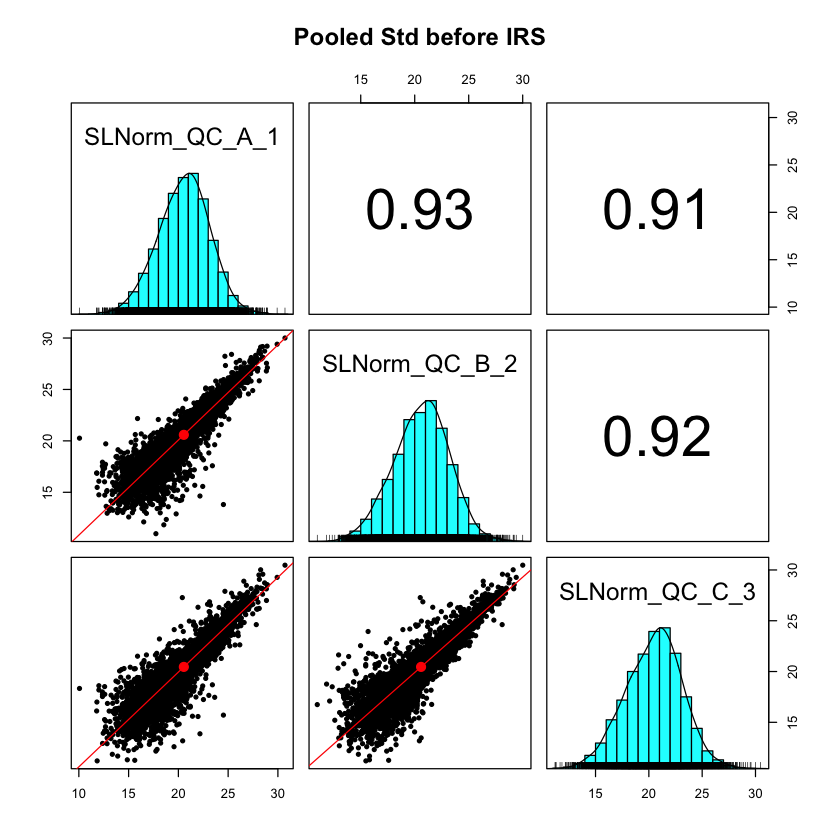

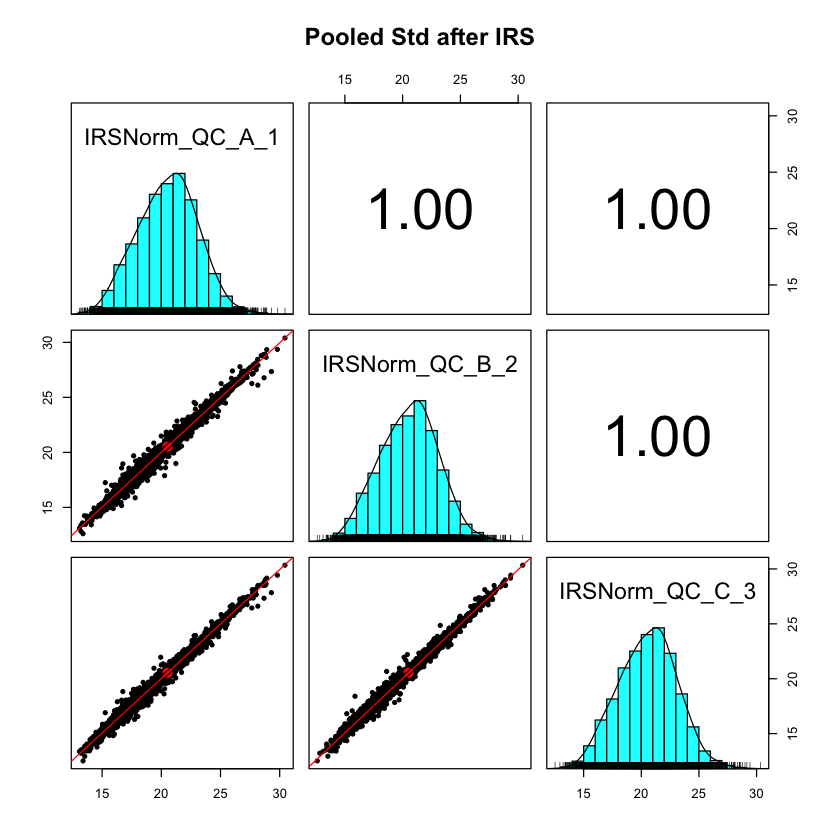

In [5]:
# multi-panel scatter plot grids from the psych package
pairs.panels(log2(sl_pool), lm = TRUE, main = "Pooled Std before IRS")
pairs.panels(log2(irs_pool), lm = TRUE, main = "Pooled Std after IRS")

## Scatter plots between plexes are terrible before IRS

The random sampling of MS2 scans is why the before IRS scatter plots are horrible. We are using the average of all 10 channels (which includes the pooled channel) for the IRS method in this notebook. We can use the pooled standard channel to check the IRS correction. The IRS method dramatically reduces the scatter in the data. Remember that this is an identical sample added to each plex. We should expect to get the same protein intensities in all plexes. 

## We can also compare samples by condition before and after IRS

Since we have a lot of samples, we will randomly look at a few.

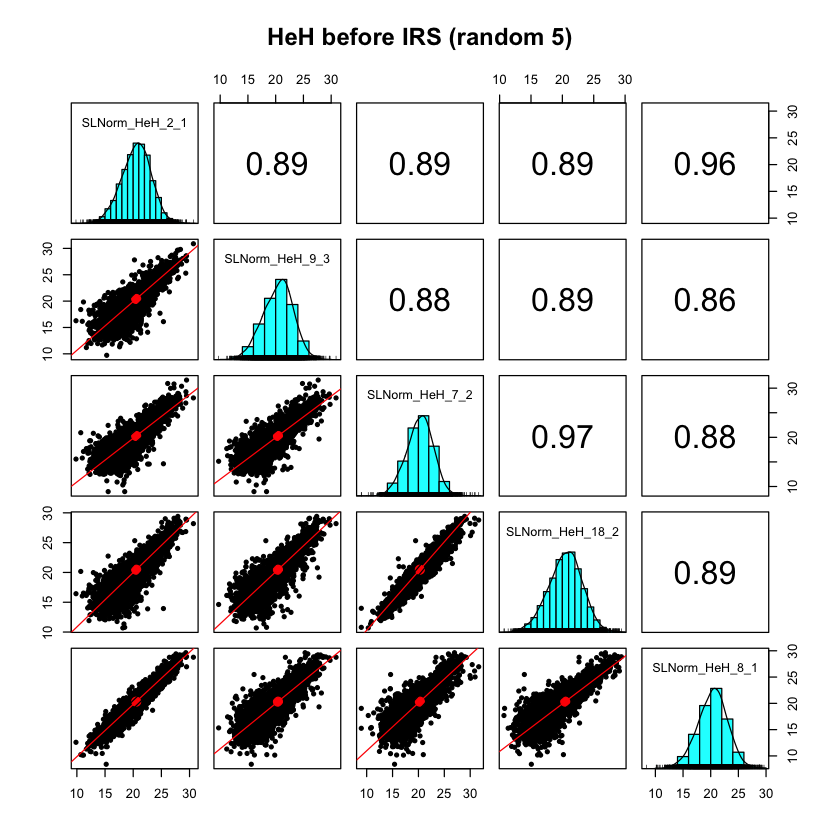

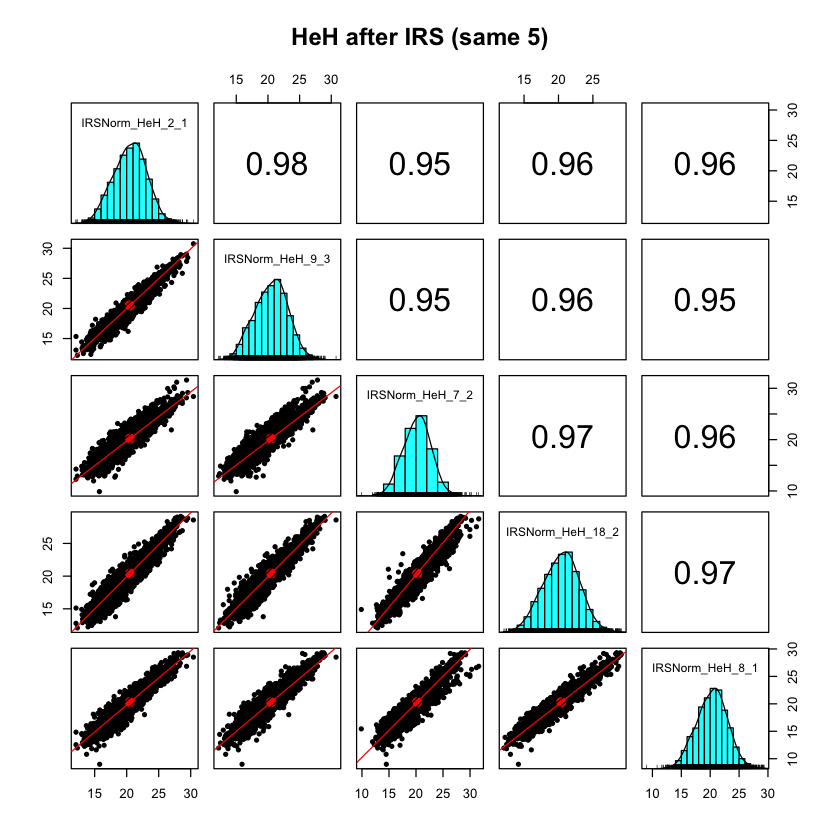

In [6]:
# multi-panel scatter plot grids
heh_sample <- sample(1:18, 5)
pairs.panels(log2(sl_HeH[heh_sample]), lm = TRUE, main = "HeH before IRS (random 5)")
pairs.panels(log2(irs_HeH[heh_sample]), lm = TRUE, main = "HeH after IRS (same 5)")

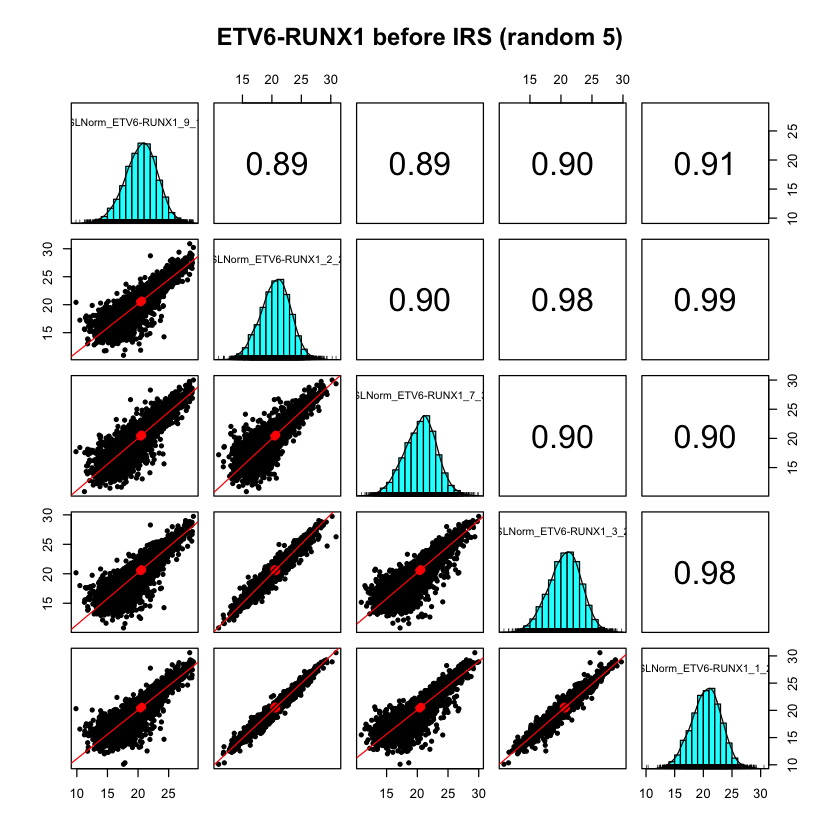

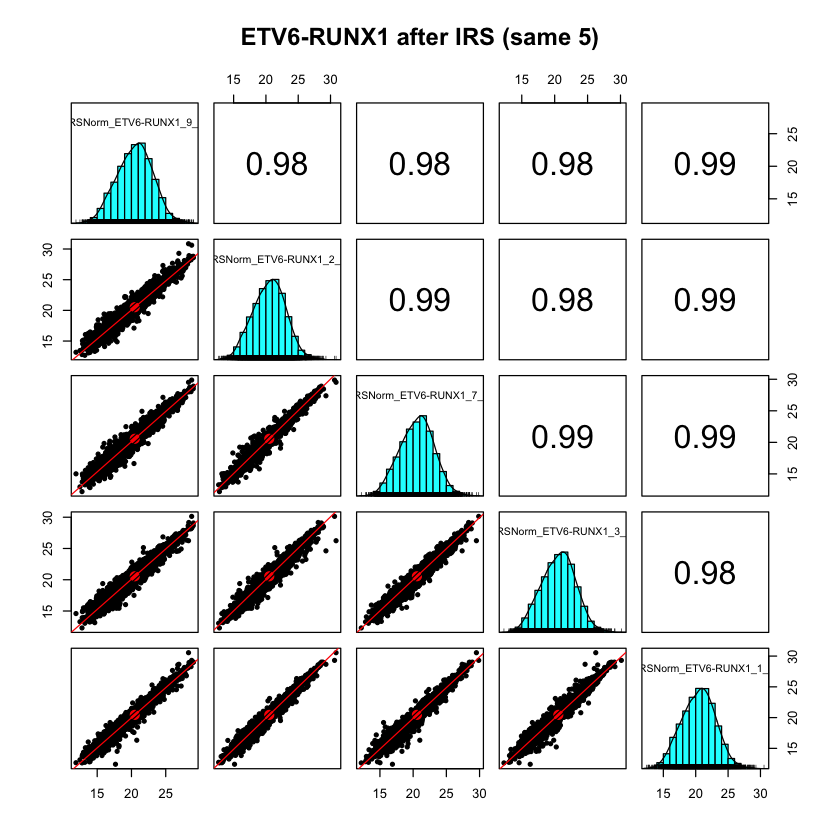

In [7]:
# multi-panel scatter plot grids
etv6_sample  <- sample(1:9, 5)
pairs.panels(log2(sl_ETV6[etv6_sample]), lm = TRUE, main = "ETV6-RUNX1 before IRS (random 5)")
pairs.panels(log2(irs_ETV6[etv6_sample]), lm = TRUE, main = "ETV6-RUNX1 after IRS (same 5)")

### The IRS method is working well

## EdgeR has another very useful data visualization
A multi-dimensional scaling plot (similar to hierarchical clustering or PCA plots) is a good way to check the data. We should expect the samples to group by condition. We can do the clustering before and after IRS to verify that we are able to recovery the true biological differences between groups. We need to load the data into some edgeR data structures and make a couple of function calls to generate the cluster plots.

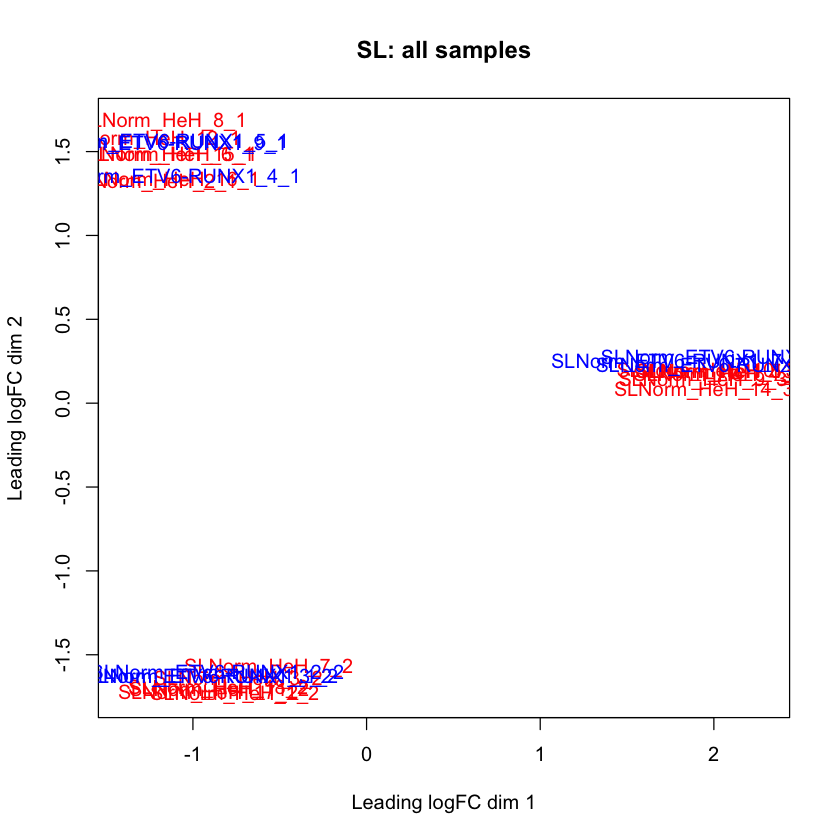

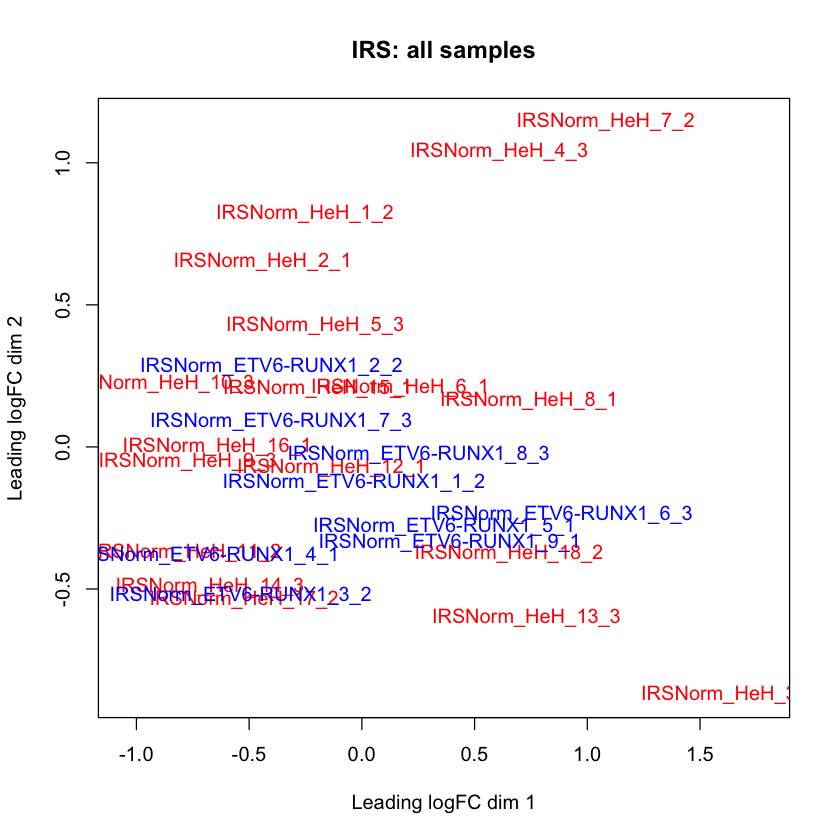

In [8]:
# get the biological sample data into a DGEList object
group = c(rep('HeH', 18), rep('ETV6', 9))
y_sl <- DGEList(counts = cbind(sl_HeH, sl_ETV6), group = group, genes = accessions)
y_irs <- DGEList(counts = cbind(irs_HeH, irs_ETV6), group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y_sl <- calcNormFactors(y_sl)
y_irs <- calcNormFactors(y_irs)

# set some colors by condition
colors = c(rep('red', 18), rep('blue', 9))

# check the clustering
plotMDS(y_sl, col = colors, main = "SL: all samples")
plotMDS(y_irs, col = colors, main = "IRS: all samples")

## Samples cluster by TMT experiment without IRS correction

The **top** MDS plot shows the first TMT experiment on the left and the second experiment on the right. After IRS, (**bottom** plot) we have the biological-condition clustering. 

## Load IRS normalized data into edgeR DGEList object <a name="load_edger"></a>
We need to get the data into some edgeR objects to work with. We do not want to include the pooled standard channels with the biological sample channels for the edgeR testing. The pooled standards are technical replicates and have a very different variance behavior compared to the biological replicates. We can call the calcNormFactors function to perform library size and the trimmed mean of M-values (TMM) normalization. EdgeR combines these two normalizations into one function call. The library size corrections are somewhat redundant because that was done as part of the IRS procedure. The TMM normalization was designed for 'omics data and it makes sense to apply that after we have done the IRS correction. The TMM normalization corrects for compositional differences between biological conditions. If some abundant proteins change expression, since we have equal total amounts of protein per sample, that will make all other protein abundances change to compensate. TMM normalization will detect and correct these situations.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

In [9]:
# we do not want the technical replicates in the mix for dispersion estimates
irs <- cbind(irs_HeH, irs_ETV6)

# load a new DGEList object (need to update the groups)
y <- DGEList(counts = irs, group = group, genes = accessions) # group was set above
y <- calcNormFactors(y)

# see what the normalization factors look like
y$samples

group lib.size    norm.factors
IRSNorm_HeH_8_1        HeH   57870355719 0.9296769   
IRSNorm_HeH_15_1       HeH   57965713567 0.9814832   
IRSNorm_HeH_16_1       HeH   59871673389 1.0279600   
IRSNorm_HeH_6_1        HeH   59154995295 1.0012258   
IRSNorm_HeH_12_1       HeH   57489447183 1.0009590   
IRSNorm_HeH_2_1        HeH   59739179789 1.0245988   
IRSNorm_HeH_7_2        HeH   58877401172 0.8234293   
IRSNorm_HeH_3_2        HeH   59185469017 0.8291643   
IRSNorm_HeH_1_2        HeH   58176452177 1.0050229   
IRSNorm_HeH_17_2       HeH   59188352963 1.0852523   
IRSNorm_HeH_11_2       HeH   59592272090 1.0815982   
IRSNorm_HeH_18_2       HeH   59000059337 0.9712209   
IRSNorm_HeH_13_3       HeH   58978727679 0.9867864   
IRSNorm_HeH_4_3        HeH   59065308586 0.9646261   
IRSNorm_HeH_14_3       HeH   59726760371 1.0871793   
IRSNorm_HeH_9_3        HeH   59159660999 1.0629018   
IRSNorm_HeH_10_3       HeH   57151178199 0.9534786   
IRSNorm_HeH_5_3        HeH   59096200057 0.8936458   
IRSNorm_ETV6-RUNX1_9_1 ETV6  59150193075 1.0373494   
IRSNorm_ETV6-RUNX1_5_1 ETV6  58763330097 1.0172524   
IRSNorm_ETV6-RUNX1_4_1 ETV6  60239234066 1.0726420   
IRSNorm_ETV6-RUNX1_1_2 ETV6  59458511305 1.0026973   
IRSNorm_ETV6-RUNX1_3_2 ETV6  59467580486 1.0824984   
IRSNorm_ETV6-RUNX1_2_2 ETV6  59552565795 1.0372819   
IRSNorm_ETV6-RUNX1_8_3 ETV6  58425172607 1.0309930   
IRSNorm_ETV6-RUNX1_7_3 ETV6  59738561803 1.0710320   
IRSNorm_ETV6-RUNX1_6_3 ETV6  59671638254 1.0063190

## EdgeR normalization factors are mostly close to 1

Unless we have biological conditions with large compositional differences, we expect the library sizes and normalization factors after the calcNormFactors call to be around 1.0.

## Compute and save the normalized intensities
The visualizations in this notebook are informative, but we ultimately have to share the experimental results with the scientific community. It is important to be able to examine the underlying data that generates all of these plots. We can use the edgeR normalization factors to produce the TMM normalized data that is what the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We have to compute the normalized intensities by hand below. We will save the normalized data as the first part of a **results** data frame that we can write out at the end of the analysis.

In [10]:
# Compute the normalized intensities (start with the IRS data)
# sample loading adjusts each channel to the same average total
lib_facs <- mean(colSums(irs)) / colSums(irs)

# print("Sample loading normalization factors")
print("Library size factors")
round(lib_facs, 4)

# the TMM factors are library adjustment factors (so divide by them)
norm_facs <- lib_facs / y$samples$norm.factors

# print these final correction factors
print("Combined (lib size and TMM) normalization factors")
round(norm_facs, 4)

# compute the normalized data as a new data frame
irs_tmm <- sweep(irs, 2, norm_facs, FUN = "*")
colnames(irs_tmm) <- str_c(colnames(irs), "_TMMnorm") # add suffix to col names
# head(results) # check that the column headers are okay

[1] "Library size factors"


IRSNorm_HeH_8_1       IRSNorm_HeH_15_1       IRSNorm_HeH_16_1 
                1.0200                 1.0183                 0.9859 
       IRSNorm_HeH_6_1       IRSNorm_HeH_12_1        IRSNorm_HeH_2_1 
                0.9979                 1.0268                 0.9881 
       IRSNorm_HeH_7_2        IRSNorm_HeH_3_2        IRSNorm_HeH_1_2 
                1.0026                 0.9973                 1.0146 
      IRSNorm_HeH_17_2       IRSNorm_HeH_11_2       IRSNorm_HeH_18_2 
                0.9973                 0.9905                 1.0005 
      IRSNorm_HeH_13_3        IRSNorm_HeH_4_3       IRSNorm_HeH_14_3 
                1.0008                 0.9994                 0.9883 
       IRSNorm_HeH_9_3       IRSNorm_HeH_10_3        IRSNorm_HeH_5_3 
                0.9978                 1.0328                 0.9988 
IRSNorm_ETV6-RUNX1_9_1 IRSNorm_ETV6-RUNX1_5_1 IRSNorm_ETV6-RUNX1_4_1 
                0.9979                 1.0045                 0.9799 
IRSNorm_ETV6-RUNX1_1_2 IRSNorm_ETV6-RUNX1_3_2 IRSNorm_ETV6-RUNX1_2_2 
                0.9928                 0.9926                 0.9912 
IRSNorm_ETV6-RUNX1_8_3 IRSNorm_ETV6-RUNX1_7_3 IRSNorm_ETV6-RUNX1_6_3 
                1.0103                 0.9881                 0.9892

[1] "Combined (lib size and TMM) normalization factors"


IRSNorm_HeH_8_1       IRSNorm_HeH_15_1       IRSNorm_HeH_16_1 
                1.0972                 1.0375                 0.9591 
       IRSNorm_HeH_6_1       IRSNorm_HeH_12_1        IRSNorm_HeH_2_1 
                0.9966                 1.0258                 0.9644 
       IRSNorm_HeH_7_2        IRSNorm_HeH_3_2        IRSNorm_HeH_1_2 
                1.2175                 1.2028                 1.0096 
      IRSNorm_HeH_17_2       IRSNorm_HeH_11_2       IRSNorm_HeH_18_2 
                0.9189                 0.9158                 1.0301 
      IRSNorm_HeH_13_3        IRSNorm_HeH_4_3       IRSNorm_HeH_14_3 
                1.0142                 1.0360                 0.9091 
       IRSNorm_HeH_9_3       IRSNorm_HeH_10_3        IRSNorm_HeH_5_3 
                0.9387                 1.0832                 1.1177 
IRSNorm_ETV6-RUNX1_9_1 IRSNorm_ETV6-RUNX1_5_1 IRSNorm_ETV6-RUNX1_4_1 
                0.9620                 0.9875                 0.9135 
IRSNorm_ETV6-RUNX1_1_2 IRSNorm_ETV6-RUNX1_3_2 IRSNorm_ETV6-RUNX1_2_2 
                0.9901                 0.9170                 0.9556 
IRSNorm_ETV6-RUNX1_8_3 IRSNorm_ETV6-RUNX1_7_3 IRSNorm_ETV6-RUNX1_6_3 
                0.9799                 0.9226                 0.9830

## Check the normalizations with box plots <a name="norm_check"></a>
Box plots for well normalized data should be similar in size and the medians should align with each other. There can be problems with the data that may not be apparent with boxplots (some data distortions can average out and not appear different with boxplots). Regardless, we should have boxplots with good median alignment. Good boxplot behavior is a necessary but not sufficient requirement of proper normalization. 

We will use ggplot2 this time and flip the graph on its side, so we can read the labels easier. We need tidy (long form) data for ggplot:

In [11]:
long_results <- gather(irs_tmm, key = "sample", value = "intensity") %>%
  mutate(log_int = log10(intensity)) %>%
  extract(sample, into = 'group', ".*?_(.*?)_", remove = FALSE)
head(long_results)

sample                  group intensity log_int 
1 IRSNorm_HeH_8_1_TMMnorm HeH   418369365 8.621560
2 IRSNorm_HeH_8_1_TMMnorm HeH   131908902 8.120274
3 IRSNorm_HeH_8_1_TMMnorm HeH   722574425 8.858883
4 IRSNorm_HeH_8_1_TMMnorm HeH   505972524 8.704127
5 IRSNorm_HeH_8_1_TMMnorm HeH   611461542 8.786369
6 IRSNorm_HeH_8_1_TMMnorm HeH   561963715 8.749708

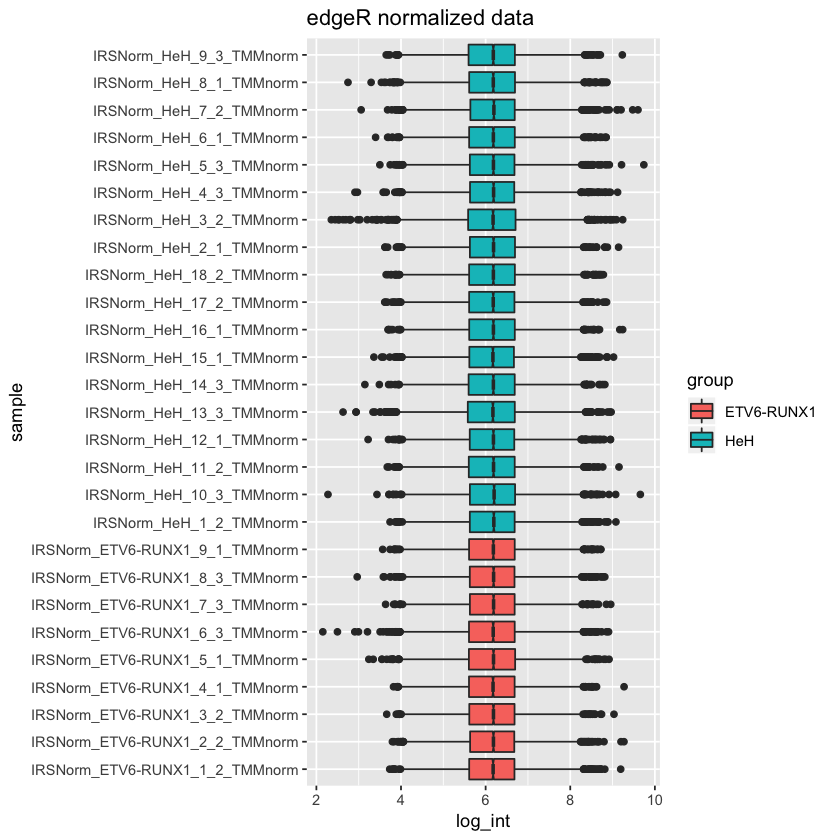

In [12]:
ggplot(long_results, aes(x = sample, y = log_int, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_flip() + 
  ggtitle("edgeR normalized data")

## Compare to standard boxplot function

ggplot2 groups the distributions by the sample groups and does the colors automatically. The standard boxplot is easy to call. We have samples grouped and the color vector already defined.

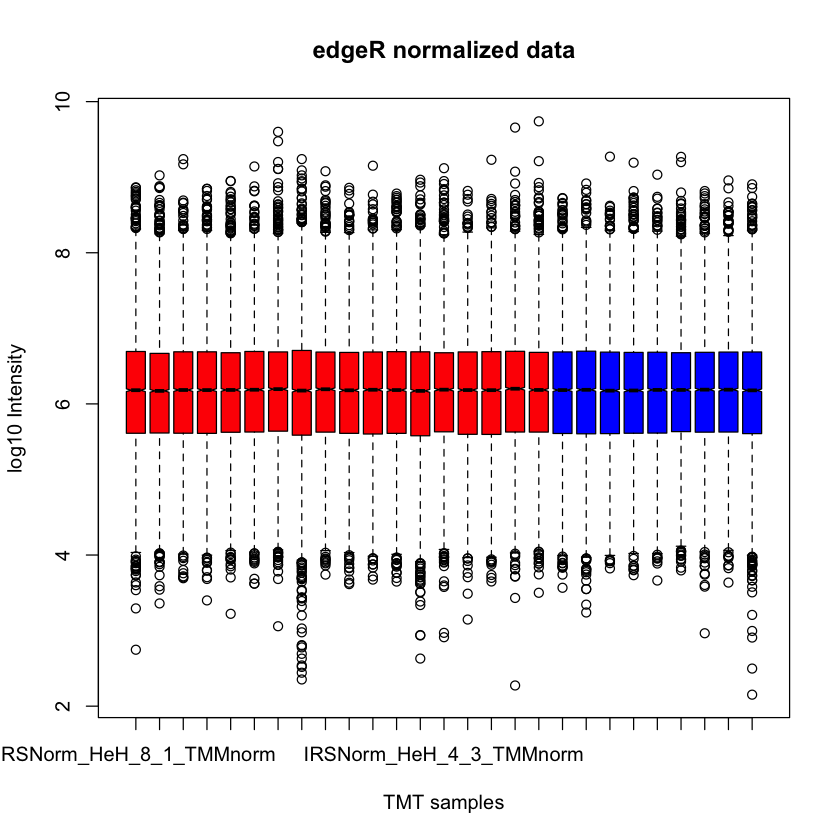

In [13]:
# look at normalized intensity distributions for each sample
boxplot(log10(irs_tmm), col = colors,
        xlab = 'TMT samples', ylab = 'log10 Intensity', 
        main = 'edgeR normalized data', notch = TRUE)

## ggplot can easily do other plot styles

Boxplots and density plots are closely related. We can easily see the smoothed density distributions for each sample.

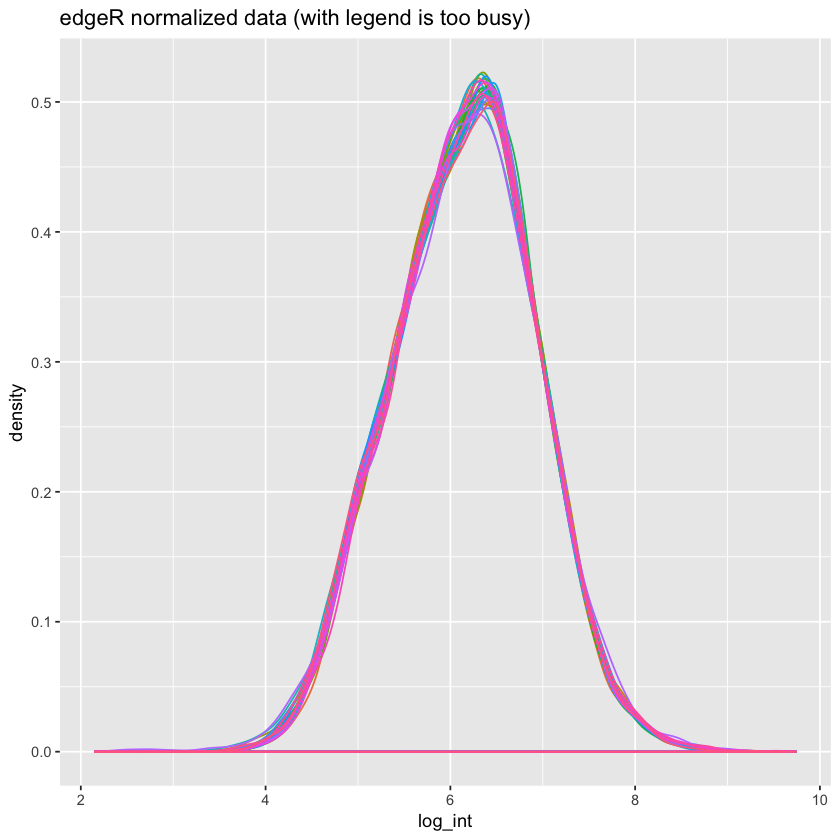

In [14]:
ggplot(long_results, aes(x = log_int, color = sample)) +
  geom_density() +
  guides(color = FALSE) +
  ggtitle("edgeR normalized data (with legend is too busy)")

## How reproducible are samples within conditions?

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This seems to be an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the two biological conditions.

In [15]:
# we can compare CVs before and after IRS
sl <- cbind(sl_HeH, sl_ETV6)

# save column indexes for different conditions (indexes to data_raw frame)
# these make things easier (and reduce the chance for errors)
HeH <- 1:18
ETV6 <- (1:9) + 18

# create a CV computing function
CV <- function(df) {
    ave <- rowMeans(df)
    sd <- apply(df, 1, sd)
    cv <- 100 * sd / ave
}

# put CVs in data frames to simplify plots and summaries
cv_frame <- data.frame(HeH.sl = CV(sl[HeH]), HeH.final = CV(irs_tmm[HeH]), 
                       ETV6.sl = CV(sl[ETV6]), ETV6.final = CV(irs_tmm[ETV6]))


# see what the median CV values are
medians <- apply(cv_frame, 2, FUN = median)
print("Median CVs by condition, before/after IRS (%)")
round(medians, 1)

[1] "Median CVs by condition, before/after IRS (%)"


HeH.sl  HeH.final    ETV6.sl ETV6.final 
      39.8       26.7       34.9       20.4

## Use ggplot to explore the CV data

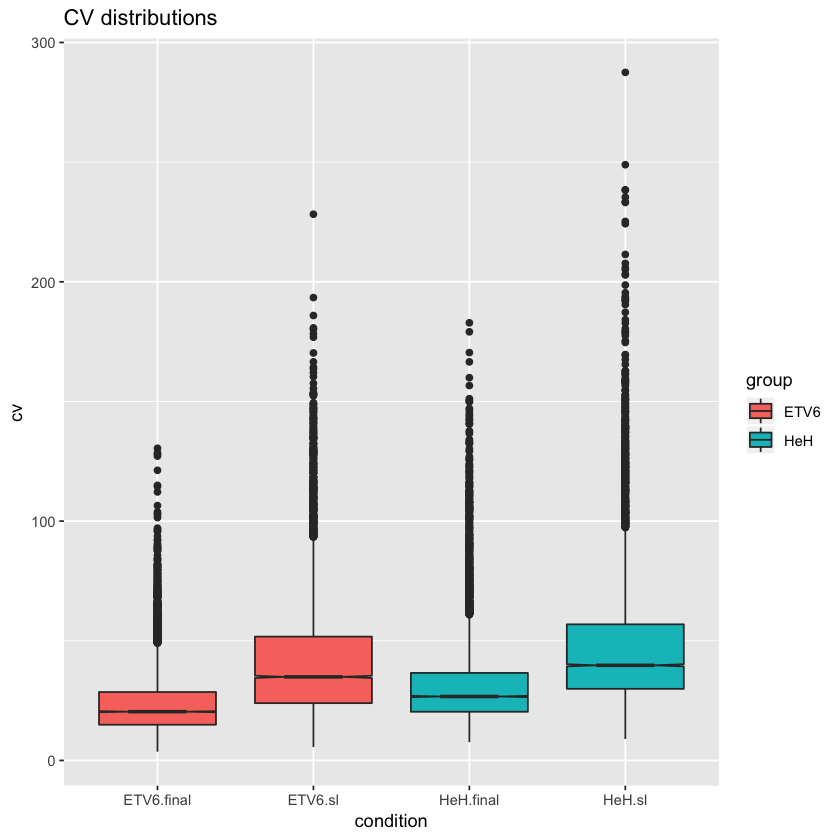

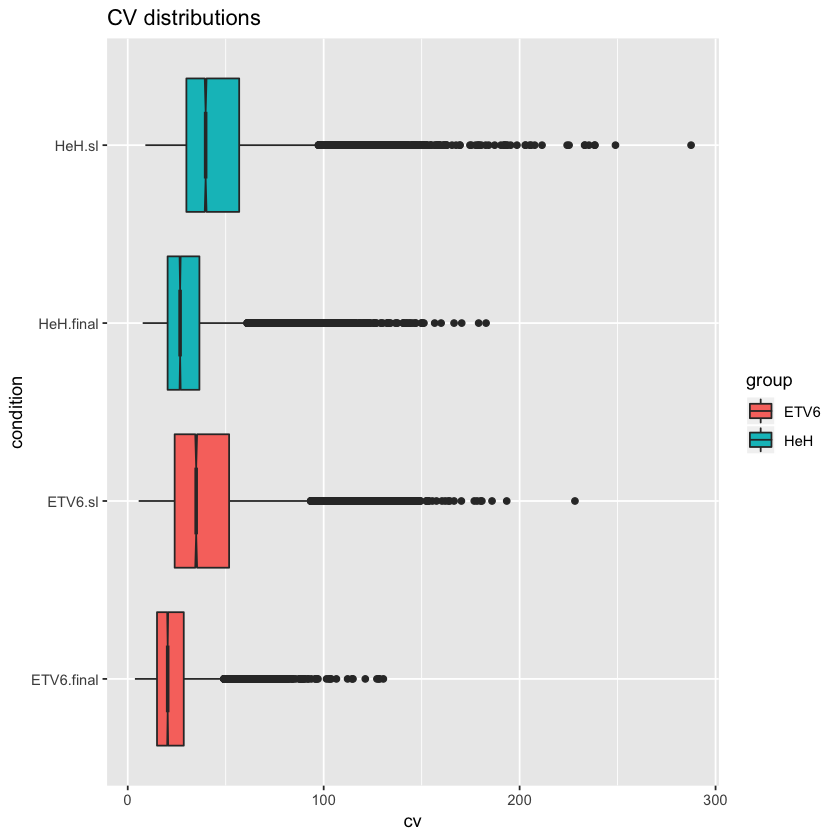

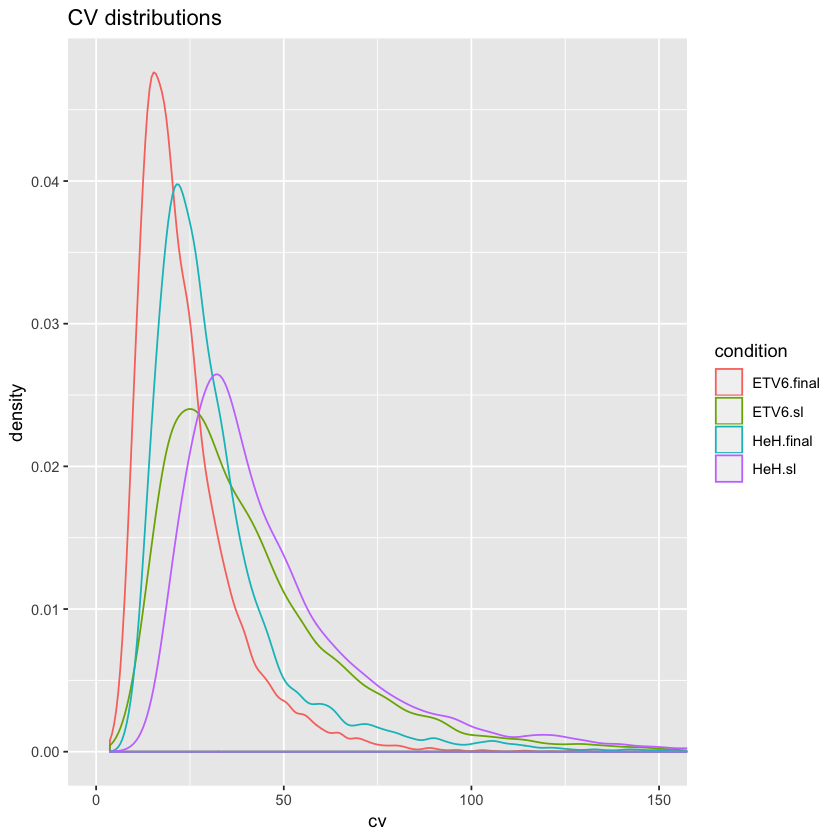

In [16]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv <- gather(cv_frame, key = "condition", value = "cv") %>%
  extract(condition, into = 'group', "(.*?)\\.+", remove = FALSE)

# traditional boxplots
cv_plot <- ggplot(long_cv, aes(x = condition, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("CV distributions")

# vertical orientation
cv_plot

# horizontal orientation
cv_plot + coord_flip()

# density plots
ggplot(long_cv, aes(x = cv, color = condition)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 150)) +
  ggtitle("CV distributions")

## Data are improved by the normalizations

The CVs improve with IRS and TMM normalizations. The median CVs get smaller, but the distributions of the CV values are much improved with considerably smaller inter-quartile ranges. We get a little better final median CVs (about 1% lower) using the plex averages compared to the single pooled standard. 


## Normalized data has been checked and looks okay

We have used scatter plots, correlation coefficients, clustering, and boxplots to verify that the IRS procedure and TMM normalization behaved as expected. None of the biological samples needed any excessive normalization factors or appeared as an outlier in the cluster views. Everything looks ready for statistical testing with edgeR.

----
# EdgeR statistical testing starts here
----

# Compare HeH to ETV6-RUNX1 samples <a name="HeH"></a>

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 27 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR estimateDisp function that does all of this and a visualization function to check the result.

We loaded the IRS data into DGEList object "y" a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in "y".

Design matrix not provided. Switch to the classic mode.


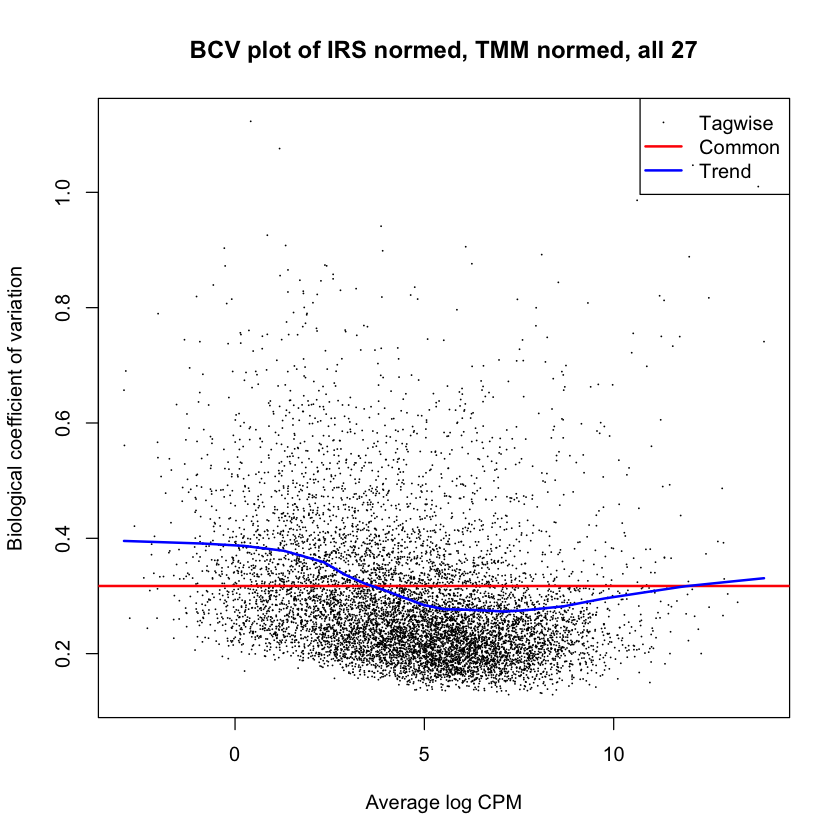

In [17]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS normed, TMM normed, all 27")

## Exact test of HeH to ETV6-RUNX1 using experiment-wide dispersion

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The decideTestsDGE call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The topTags call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from limma to visualize the DE candidates, and then check the p-value distribution.

       ETV6-HeH
Down        970
NotSig     6824
Up          962

Comparison of groups:  ETV6-HeH 
                     genes     logFC     logCPM       PValue          FDR
2767  sp|Q92784|DPF3_HUMAN  2.073160  6.0430709 5.499037e-63 4.814957e-59
484  sp|Q9NZI8|IF2B1_HUMAN  3.072770  8.6476774 2.162068e-50 9.465533e-47
350  sp|Q02952|AKA12_HUMAN  2.576431  9.0667677 8.208297e-44 2.395728e-40
3326  sp|P15918|RAG1_HUMAN  2.182582  5.5728144 9.271322e-42 2.029492e-38
3996 sp|O43374|RASL2_HUMAN  1.846408  5.0777359 1.574231e-39 2.756794e-36
4614 sp|Q9UI15|TAGL3_HUMAN  2.274957  4.3900404 9.839450e-39 1.435904e-35
5378 sp|Q52LW3|RHG29_HUMAN  1.931155  4.1127248 5.857714e-36 7.327164e-33
5138 sp|Q2M1K9|ZN423_HUMAN  1.353490  4.2704833 3.921784e-35 4.292392e-32
3983  sp|O15264|MK13_HUMAN  1.562638  5.0652848 1.347447e-32 1.310917e-29
6890  sp|O95208|EPN2_HUMAN  2.264919  2.7657996 1.397403e-30 1.223566e-27
7863 sp|Q9NR80|ARHG4_HUMAN  1.493892  1.6057332 6.656635e-28 5.298682e-25
7517 sp|P07711|CATL1_HUMAN  2.154332  1.6981901 3.028226e-27 2.209595e-24
8547 sp|Q8TCN5|ZN507_HUMAN  1.783974 -0.1676414 9.559987e-25 6.439019e-22
5613 sp|Q9BXM9|FSD1L_HUMAN  1.363625  3.9904553 1.324792e-24 8.285630e-22
8103 sp|Q92952|KCNN1_HUMAN  2.152647  0.2508497 4.220549e-22 2.463675e-19
7307 sp|Q96A56|T53I1_HUMAN  1.992787  2.4065906 2.796418e-21 1.530340e-18
3047 sp|Q5T7W0|ZN618_HUMAN  1.047679  5.7173381 2.893324e-20 1.490232e-17
2390 sp|P19174|PLCG1_HUMAN  1.277051  6.2308419 3.444823e-20 1.662114e-17
1223 sp|Q06210|GFPT1_HUMAN  1.263446  7.4156518 3.606688e-20 1.662114e-17
1164  sp|O00764|PDXK_HUMAN -1.307274  7.4216771 8.482971e-20 3.713845e-17
6141 sp|Q9Y4F1|FARP1_HUMAN  1.593507  3.3440723 9.511541e-20 3.965860e-17
4589 sp|Q9NZA1|CLIC5_HUMAN  1.895925  4.6241309 4.252804e-19 1.692616e-16
235   sp|P33241|LSP1_HUMAN -1.514363  9.4507521 5.582241e-19 2.125135e-16
1308  sp|Q8WWM9|CYGB_HUMAN  1.686876  7.2873847 9.203374e-19 3.357698e-16
5165 sp|O75363|BCAS1_HUMAN  1.887822  4.1724623 9.872646e-19 3.457795e-16

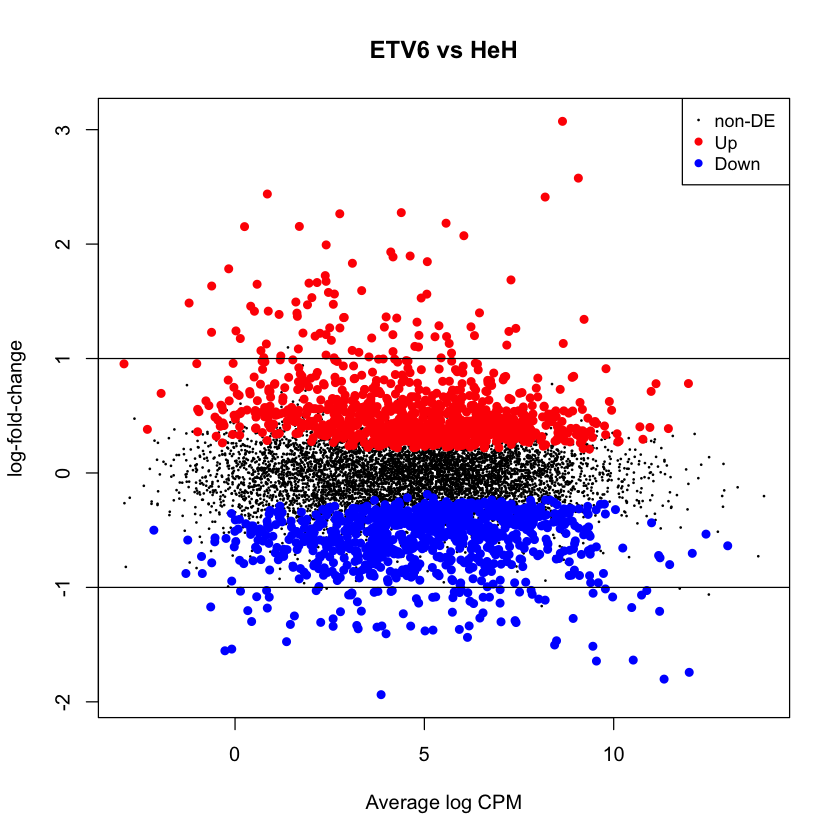

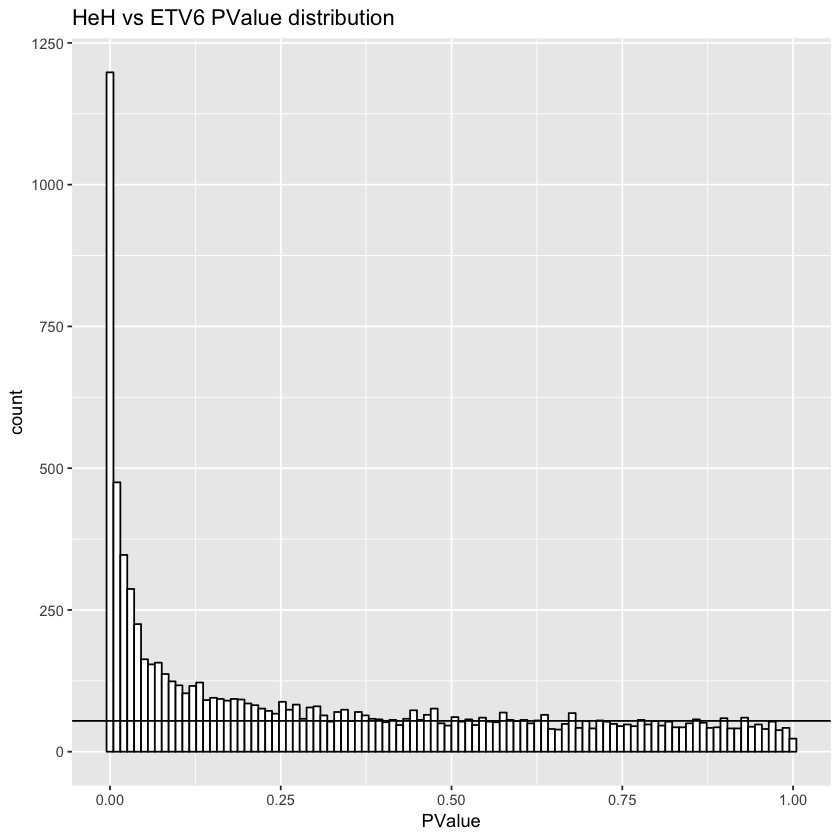

In [18]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("HeH", "ETV6"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et, n = 25)
tt <- topTags(et, n = Inf, sort.by = "none")
tt <- tt$table    # tt is a list. We just need the "table" data frame

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("HeH vs ETV6 PValue distribution")

## Candidates and p-values look pretty good

The numbers of candidates are large and balanced between up and down regulation, as can be seen in the MA plot. The p-value distribution has a nice flat distribution for larger p-values (from non-DE candidates) and a sharp spike at small p-values from true DE candidates.

We end up with about 100 more candidates in each direction here with the 10-channel averages compared to using just the single pooled standard in the IRS method.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data).

candidate n   
1 high       765
2 med        586
3 low        581
4 no        6824

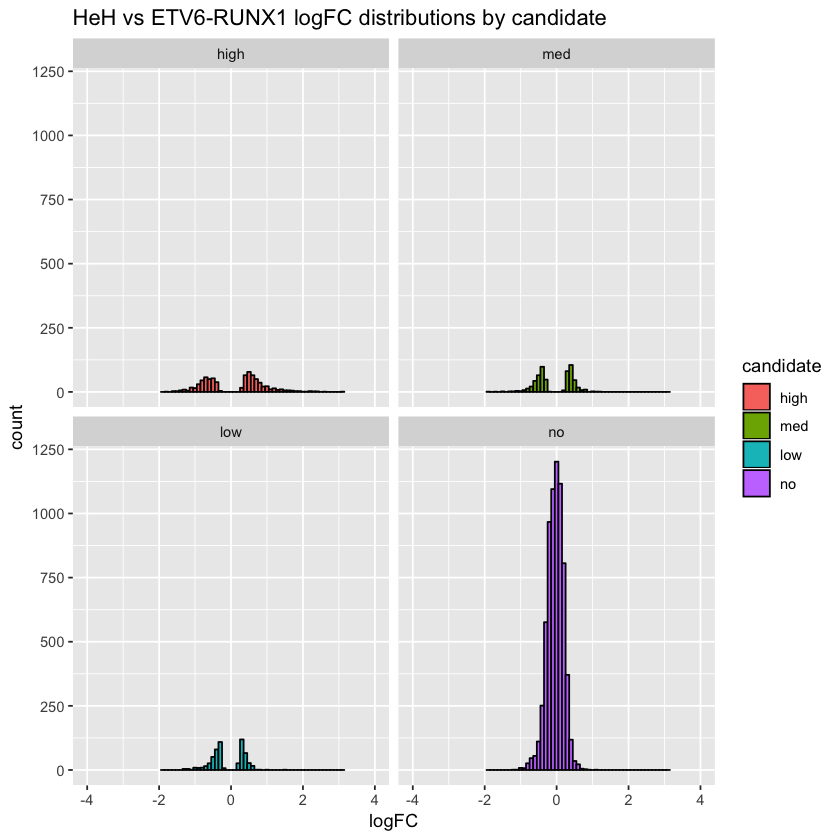

In [19]:
# get the averages within each condition 
# results already has the normalized data in its left columns
tt$ave_HeH <- rowMeans(irs_tmm[HeH])
tt$ave_ETV6 <- rowMeans(irs_tmm[ETV6])

# add the cadidate status column
tt <- tt %>%
  mutate(candidate = cut(FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0),
  labels = c("high", "med", "low", "no")))

tt %>% count(candidate)  # count candidates

ggplot(tt, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("HeH vs ETV6-RUNX1 logFC distributions by candidate")

In [20]:
# ================= reformat edgeR test results ================================

collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# get the results
results <- collect_results(irs, tt, HeH, "HeH", ETV6, "ETV6")

## Main summary plots

We have many comparisons to visualize, so we will make a function to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color.

In [21]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

## DE Candidate Plots for HeH vs ETV6-RUNX1

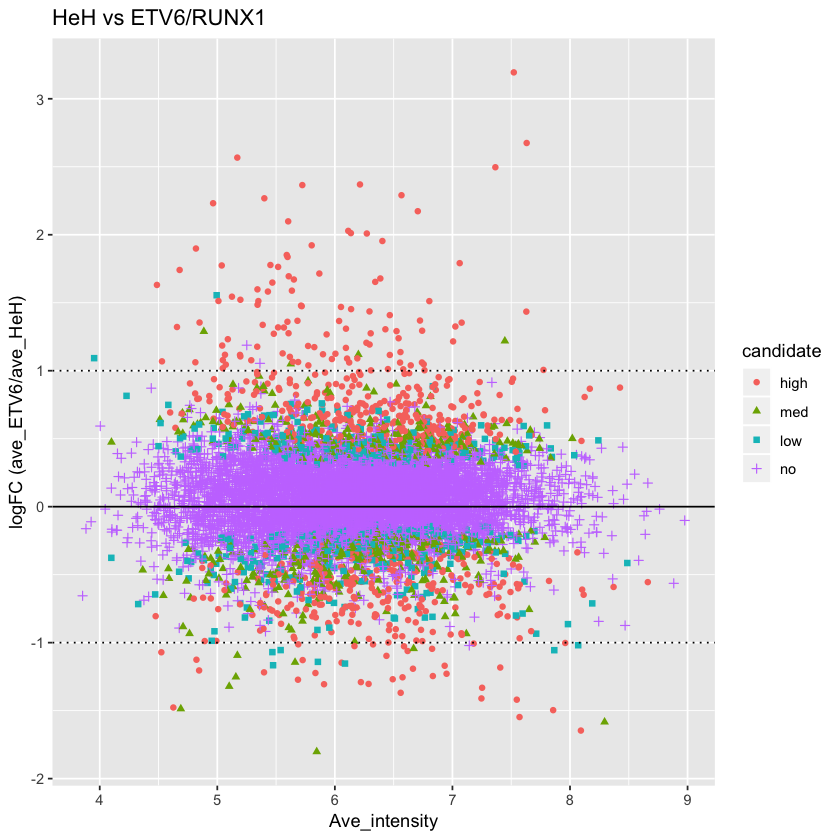

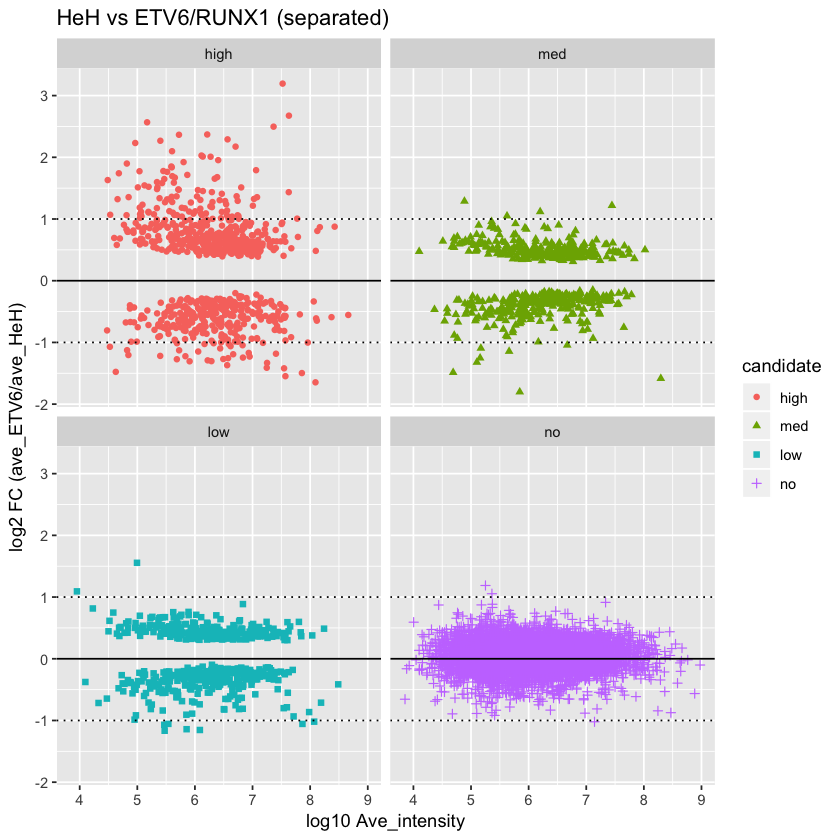

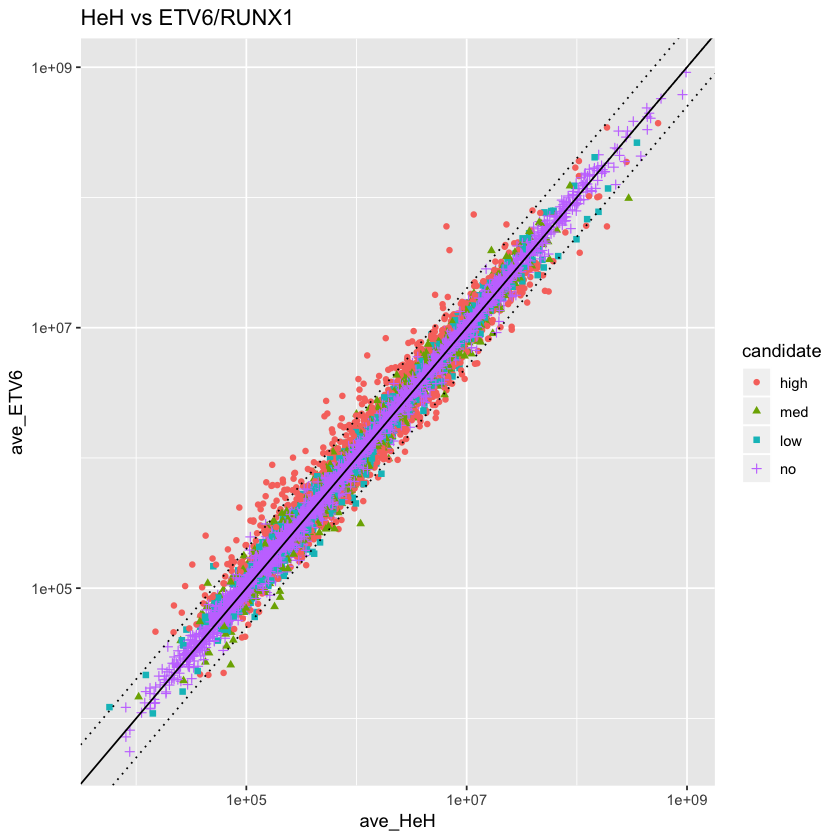

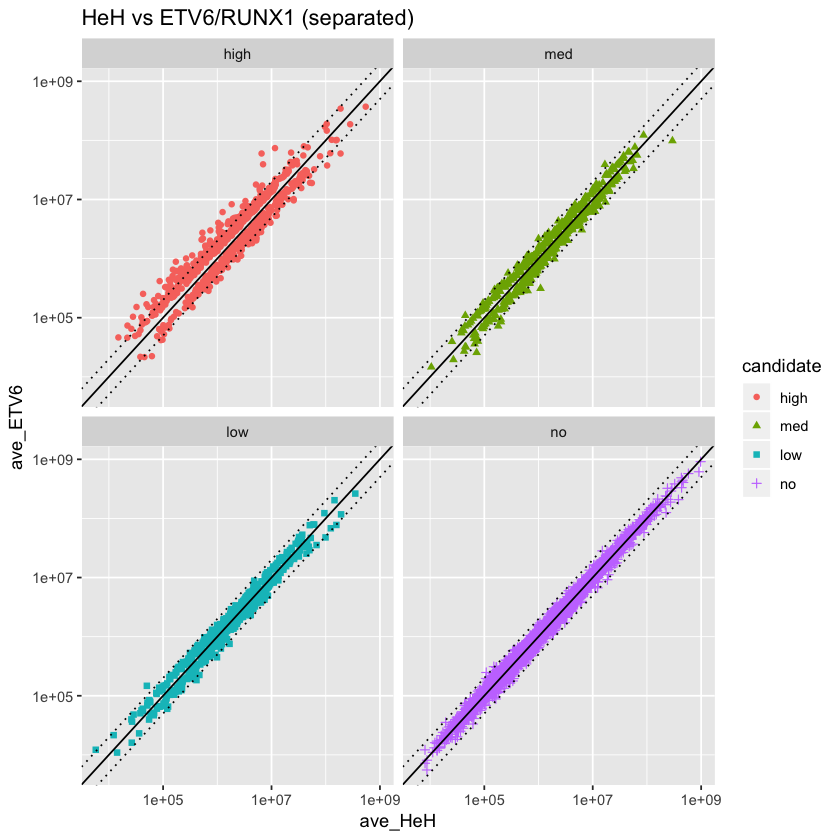

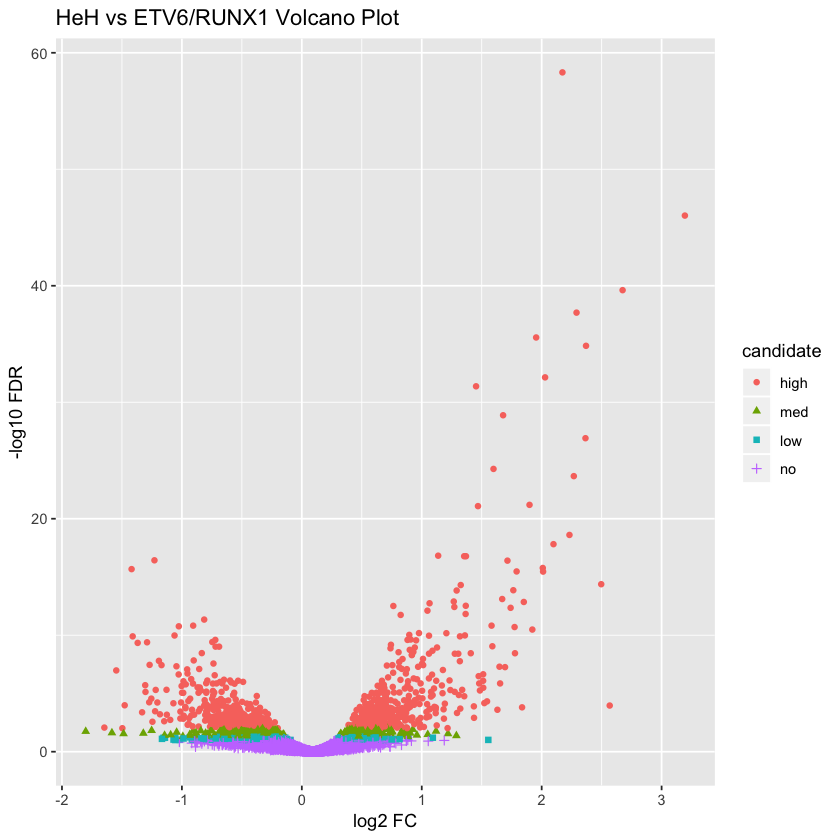

In [22]:
# make the DE plots
MA_plots(results, "ave_HeH", "ave_ETV6", "HeH vs ETV6/RUNX1")
scatter_plots(results, "ave_HeH", "ave_ETV6", "HeH vs ETV6/RUNX1")
volcano_plot(results, "ave_HeH", "ave_ETV6", "HeH vs ETV6/RUNX1")

## Many candidates are less than 2-fold

The fold-changes for candidates are not particularly large. Many of the statistically significant proteins have less than 2-fold changes. This could be due to using MS2 reporter ions instead of the newer SPS MS3 method. There are more candidates with larger fold changes that have over-expression in ETV6-RUNX1. The candidates are well spread out over the 5-decades of protein intensities.

Note: Protein total reporter ion intensity is well correlated with protein total MS1 feature intensites. In other words, it is a good relative protein abundance measure.

### Plot the reporter ions for the top 25 up and down candidates (by FDR) <a name="top50"></a>

The HeH data points are in red and the ETV6-RUNX1 samples are in blue. The protein identifier, the average intensity, the individual test p-value (not the FDR), and the traditional fold-change are used as plot labels.

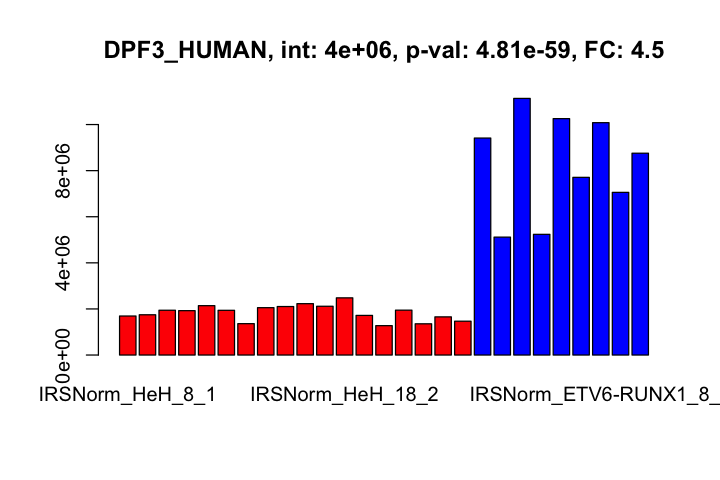

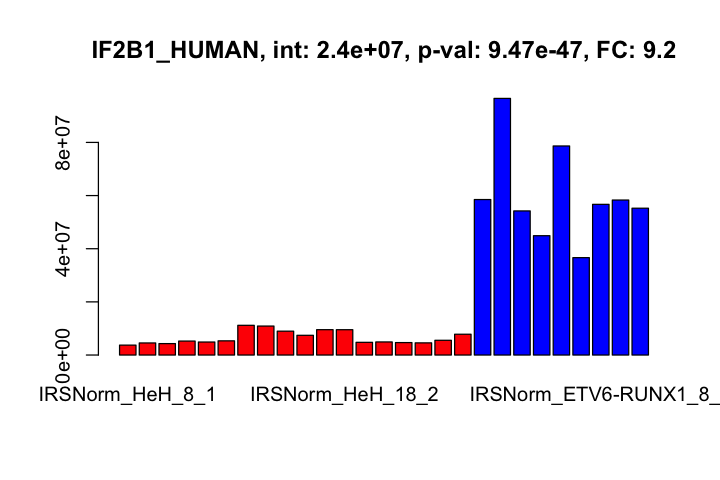

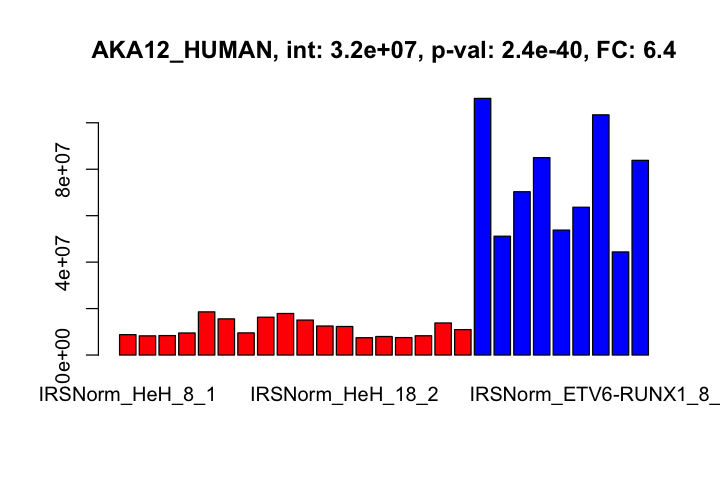

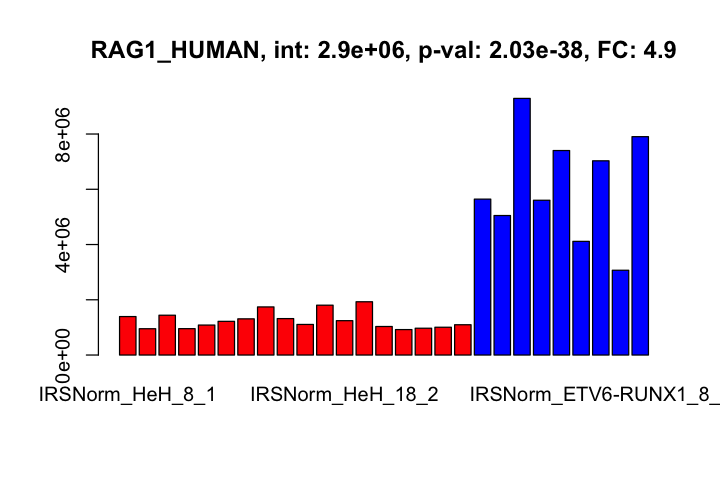

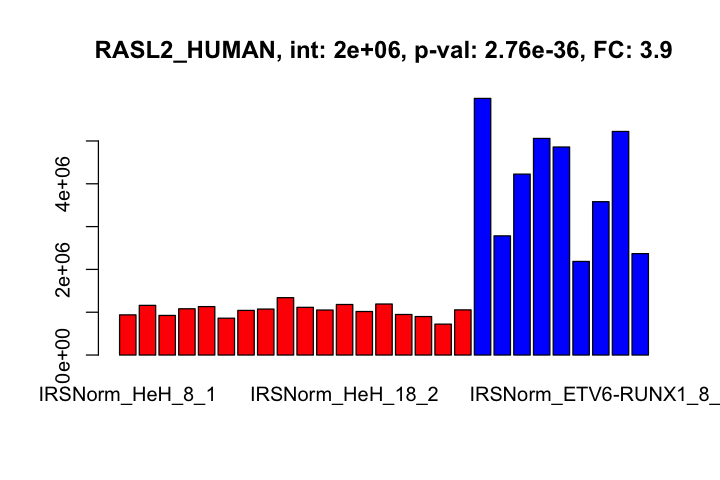

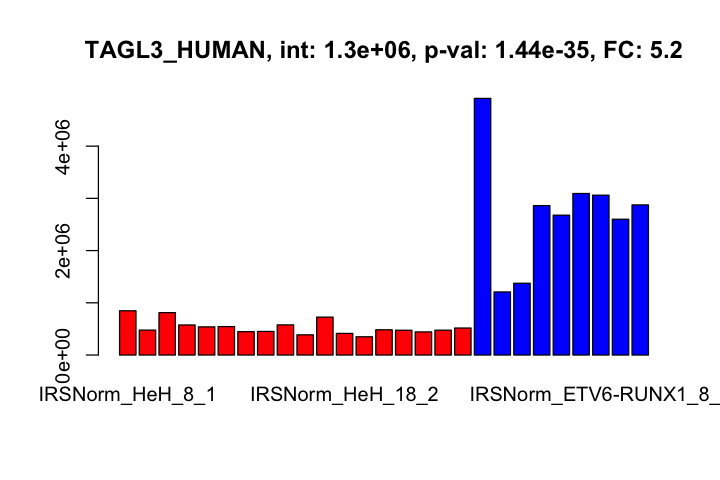

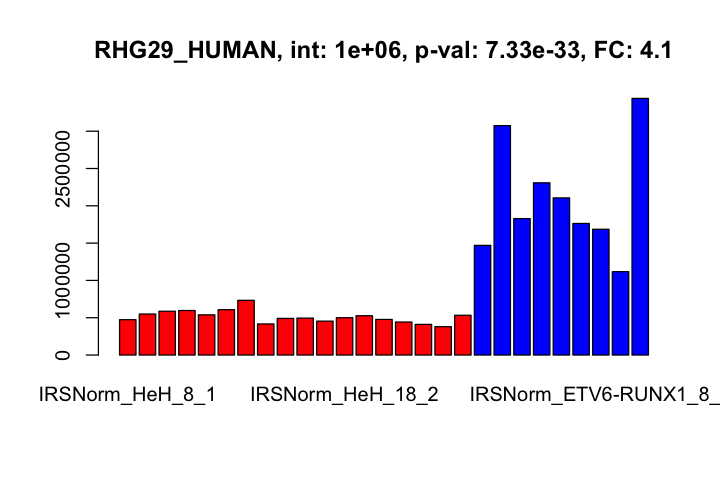

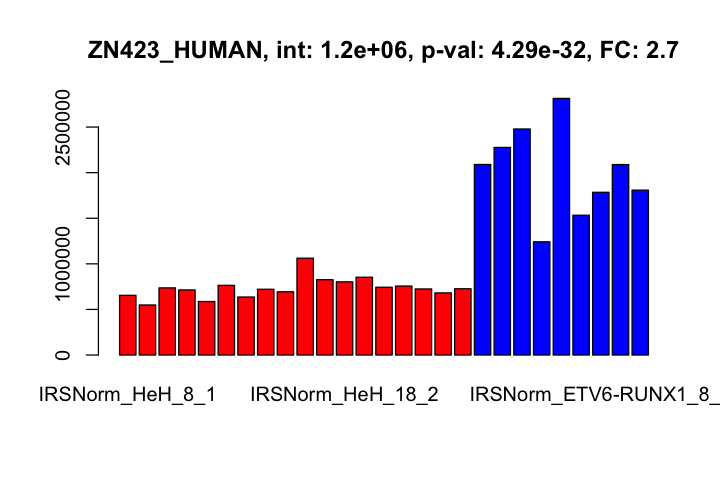

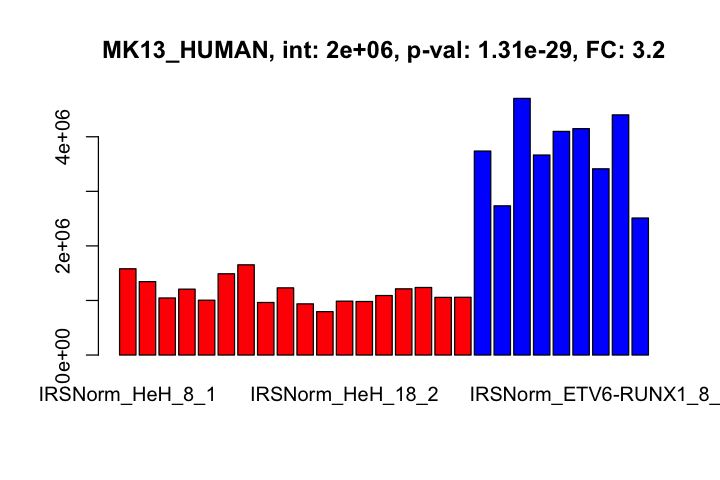

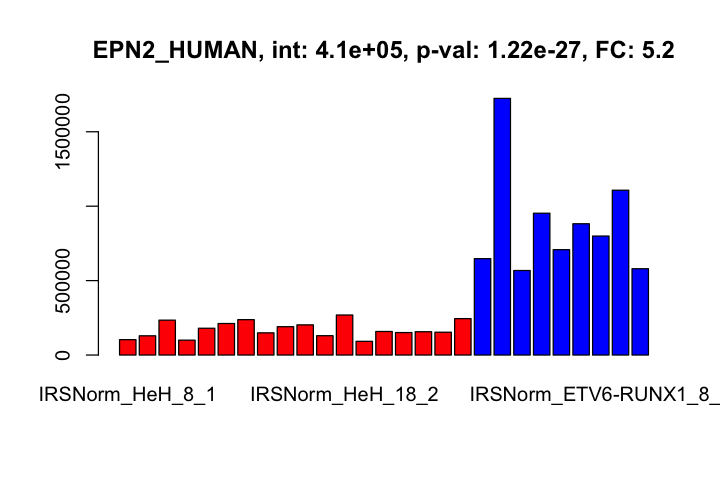

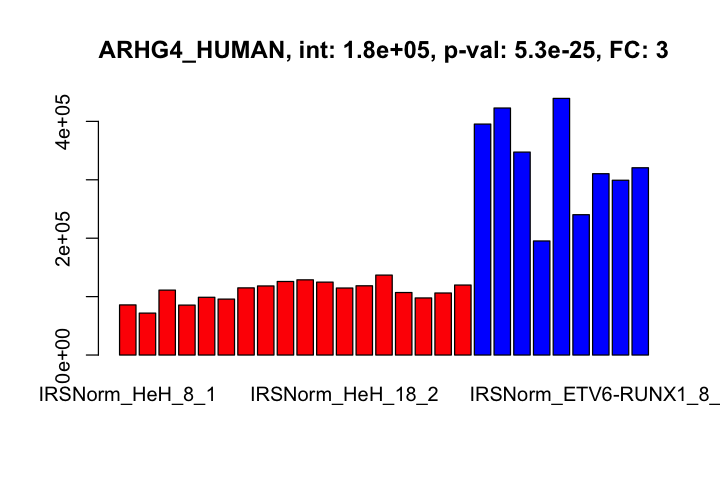

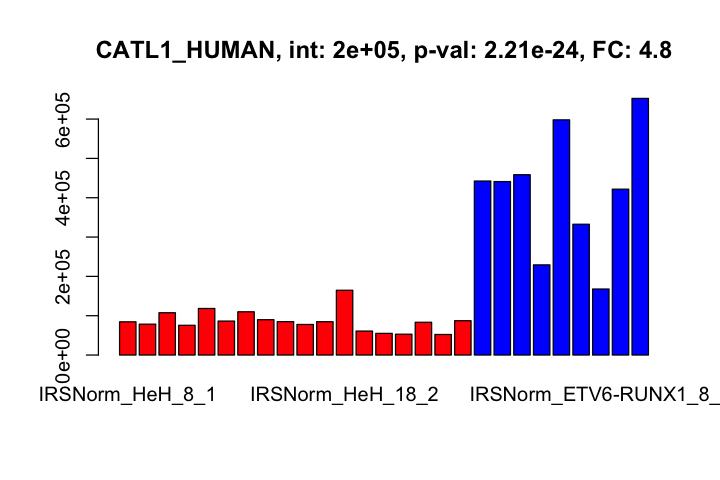

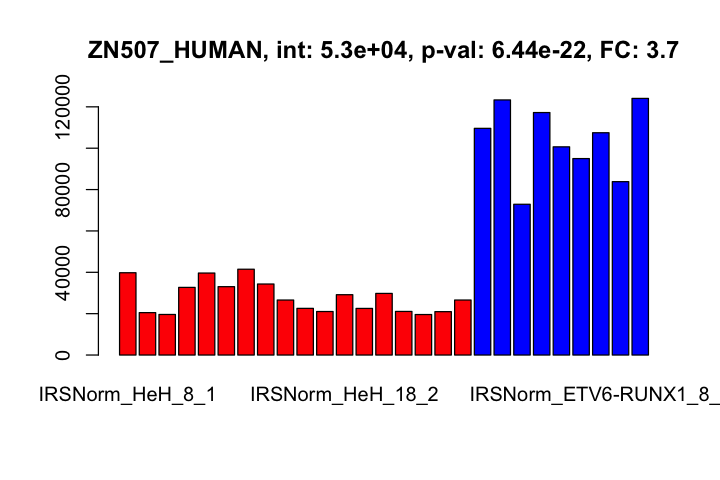

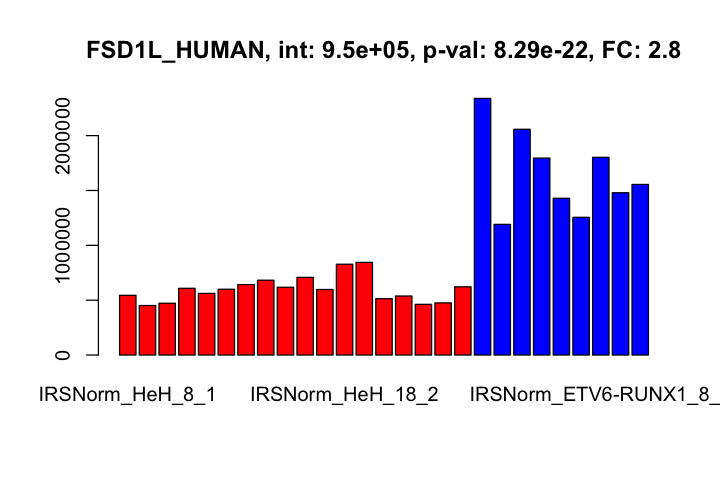

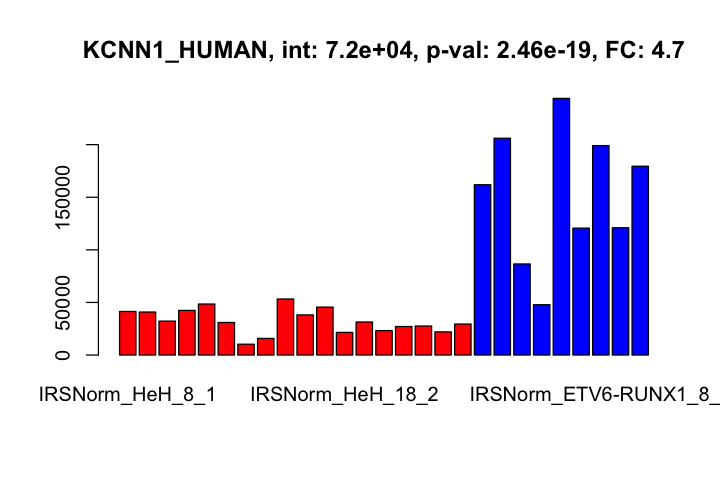

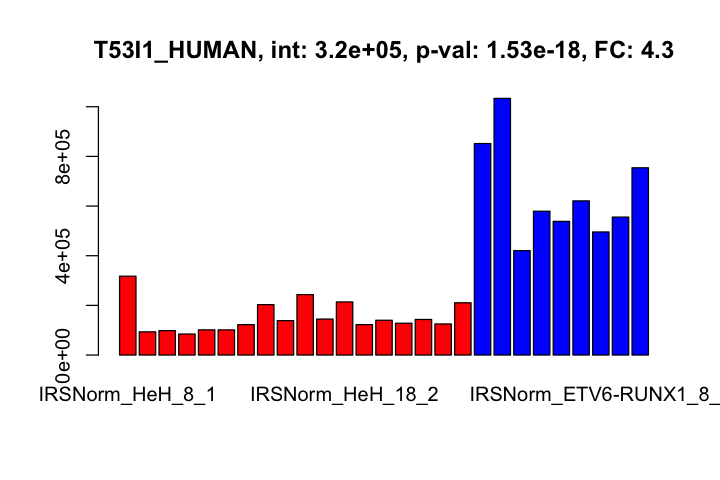

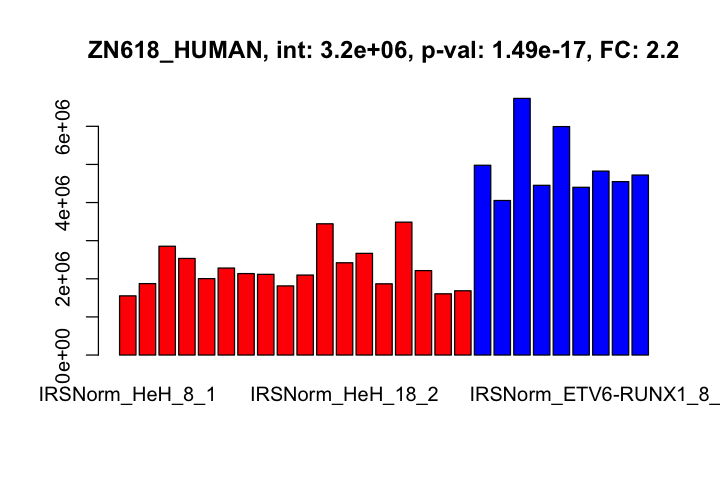

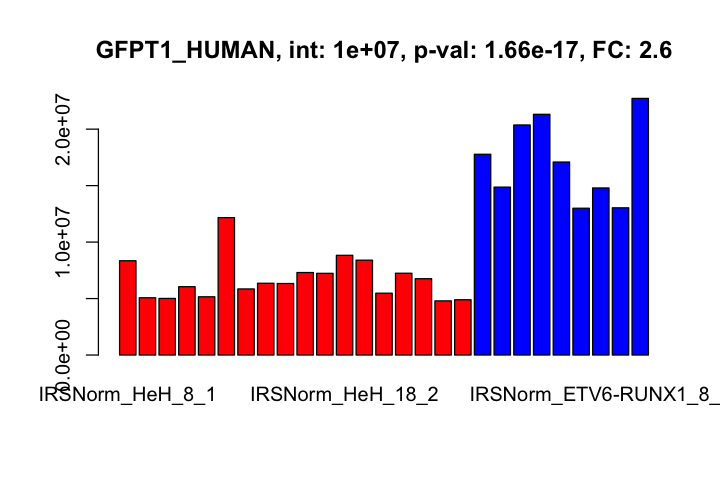

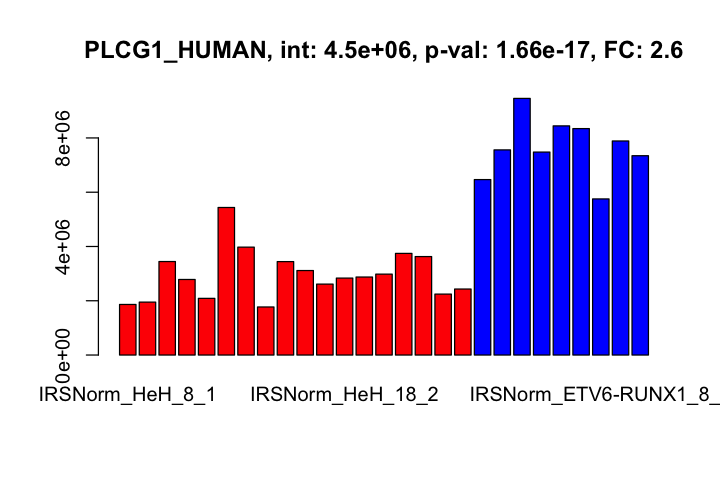

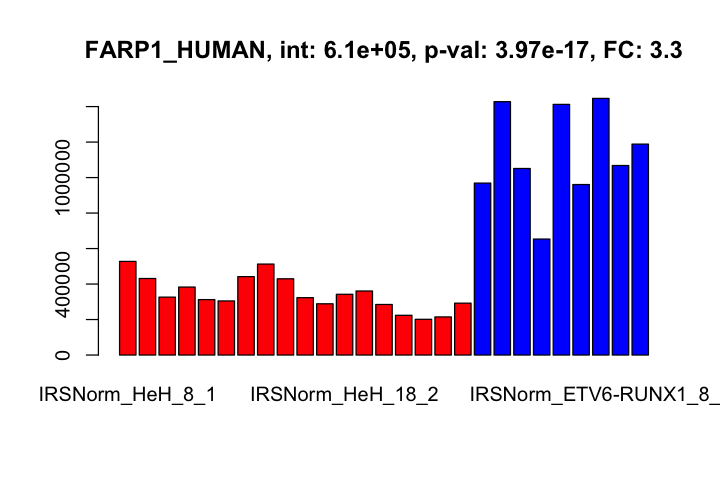

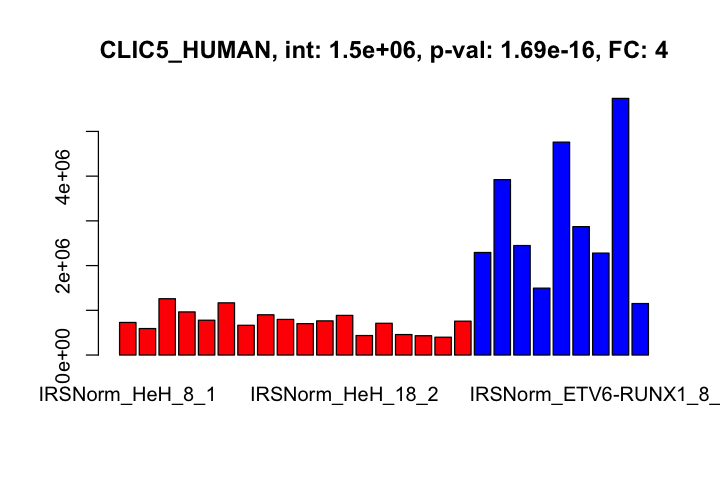

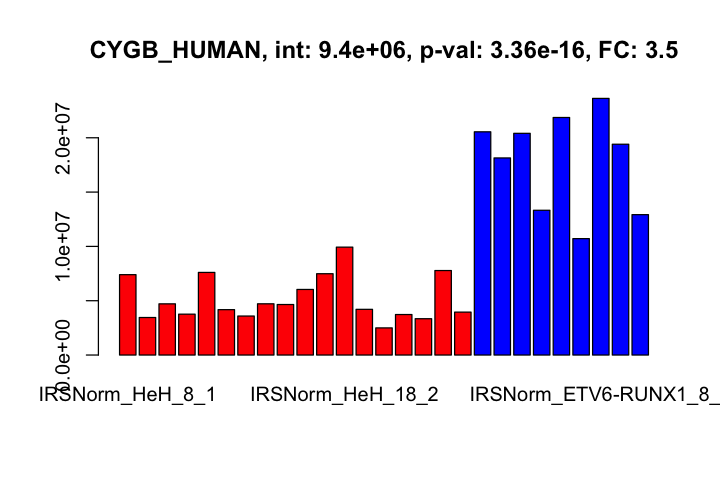

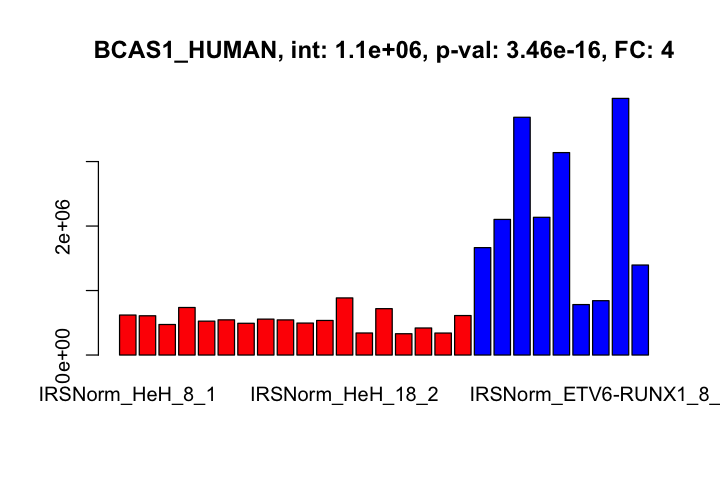

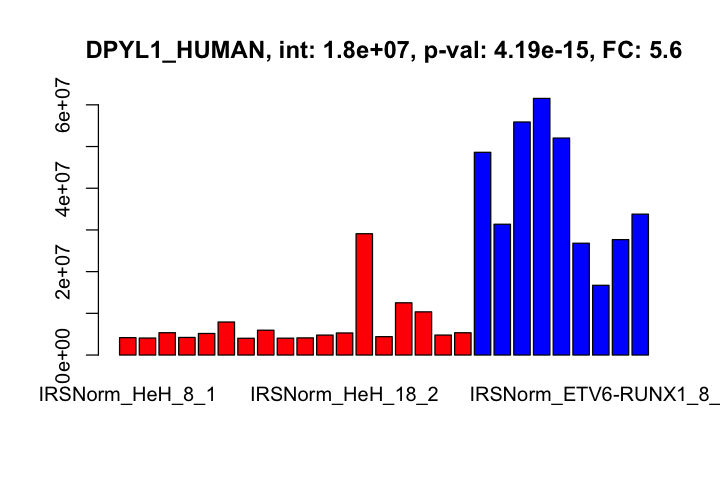

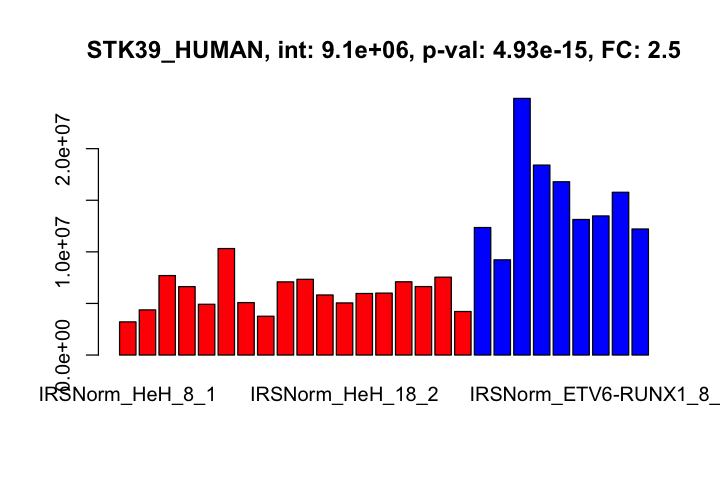

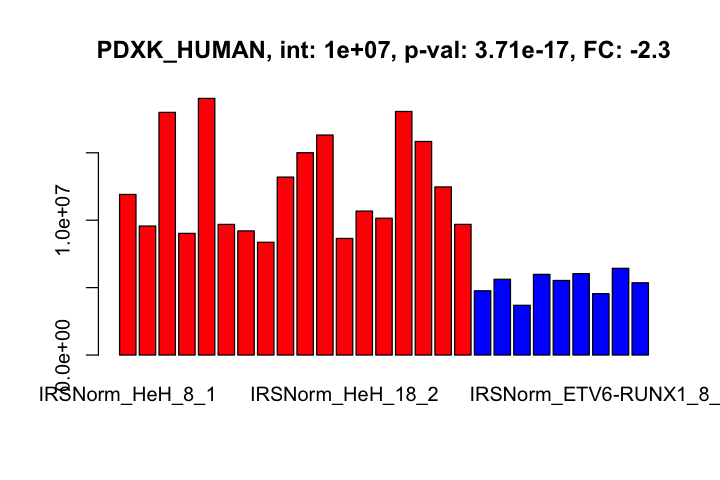

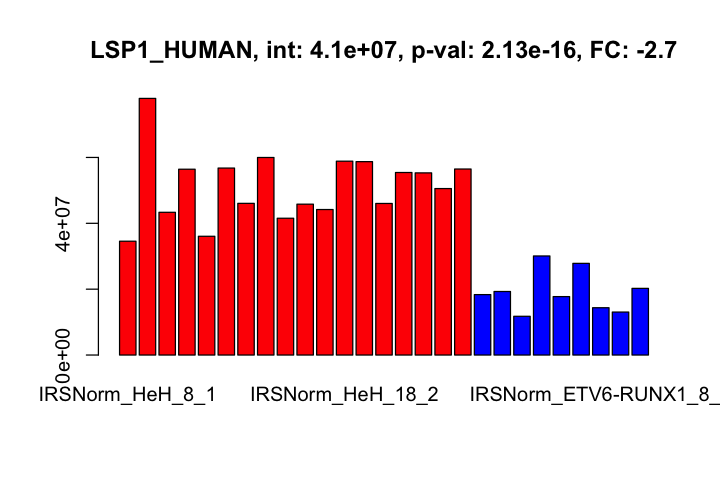

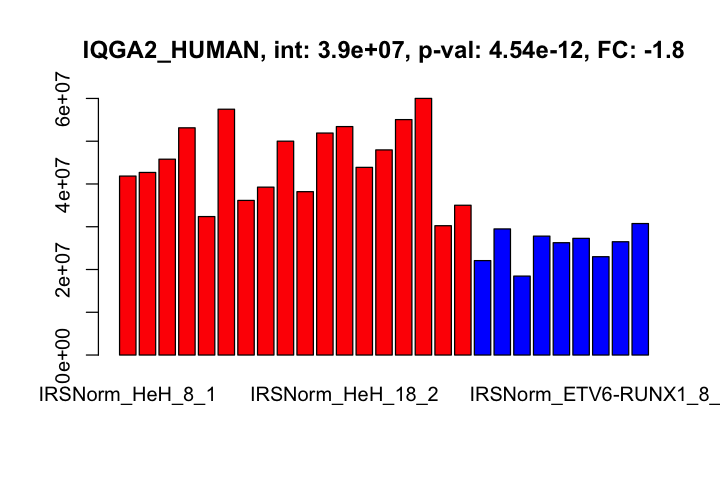

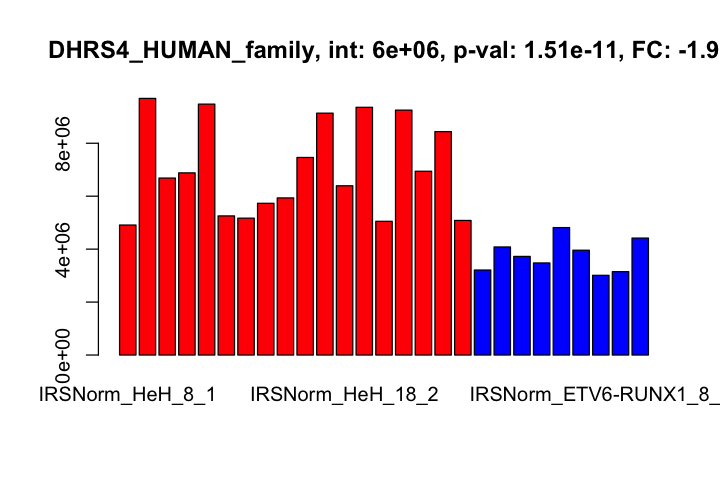

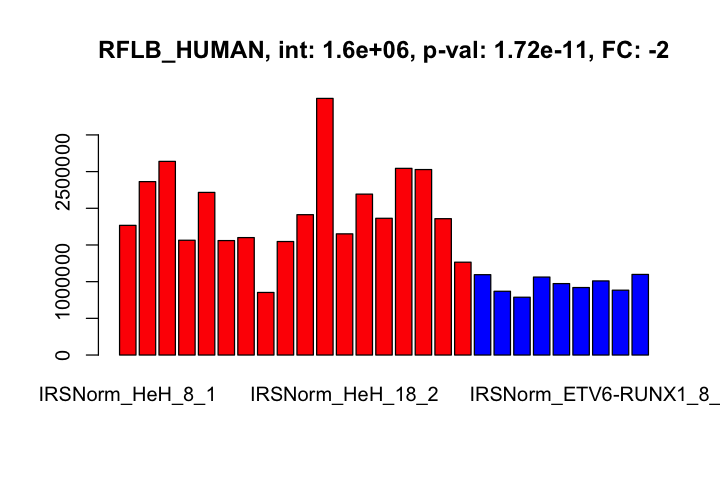

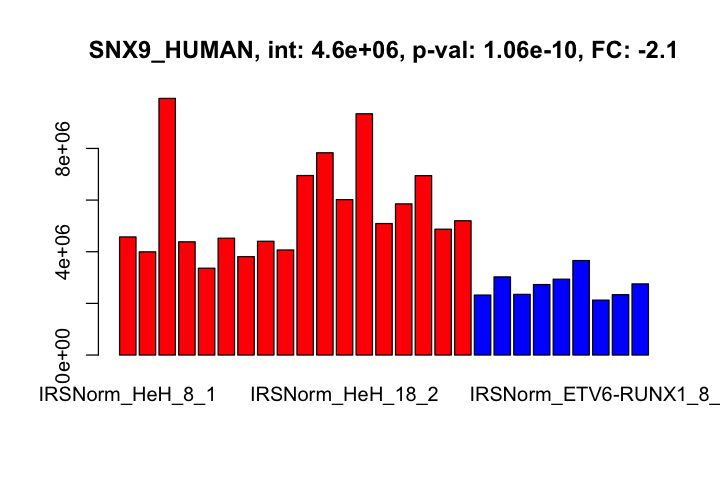

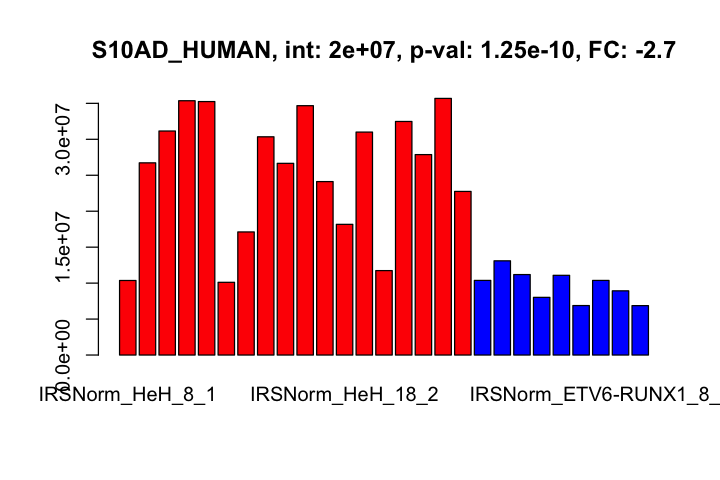

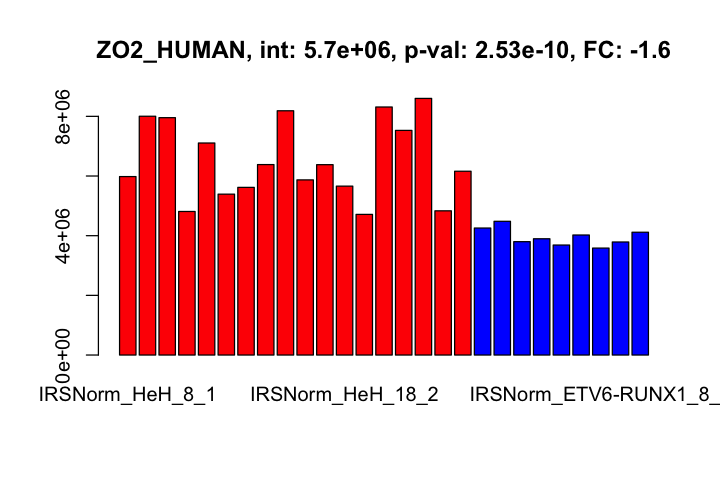

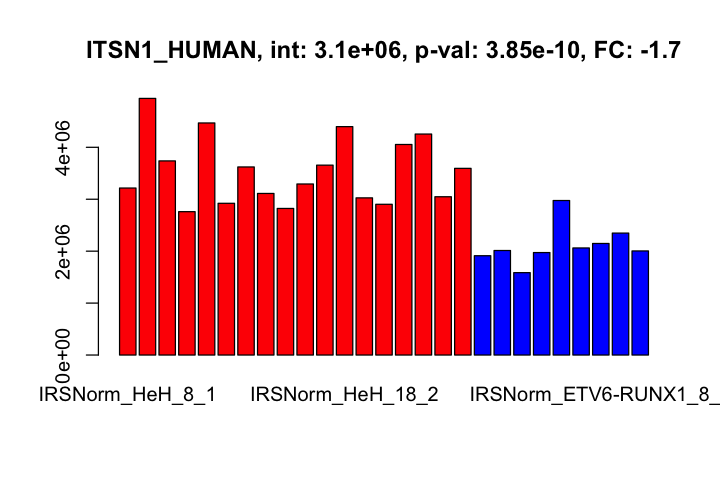

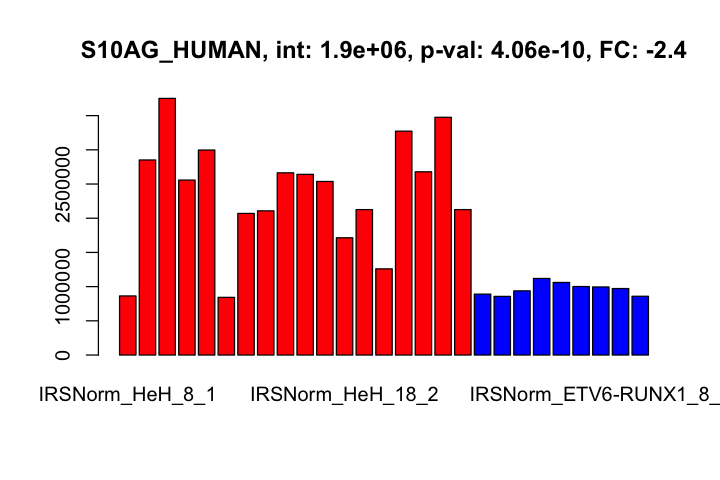

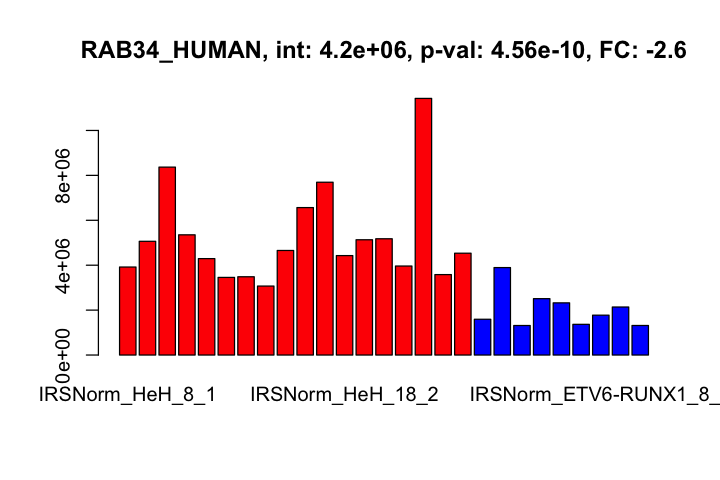

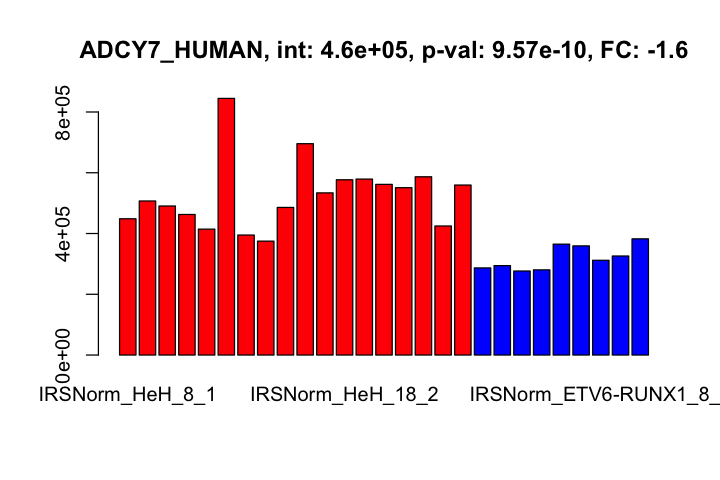

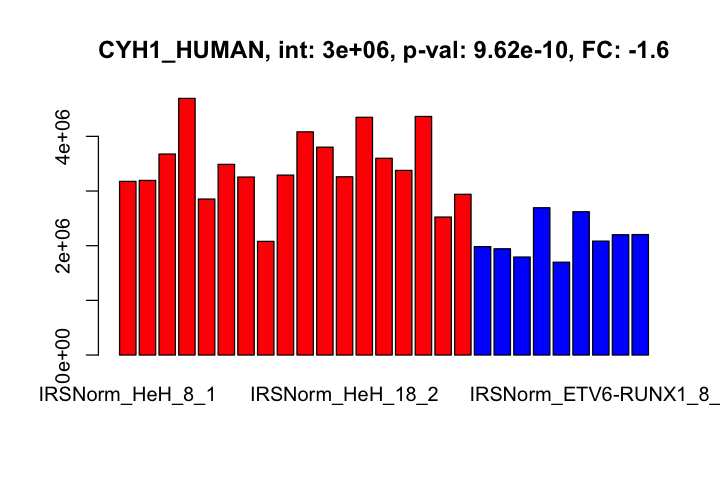

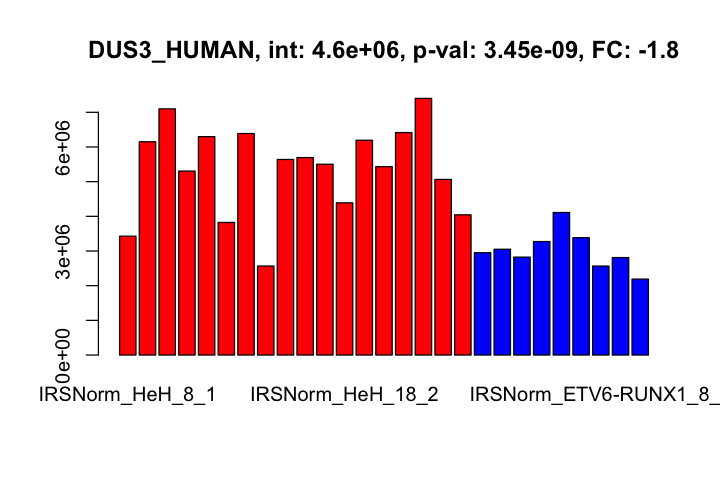

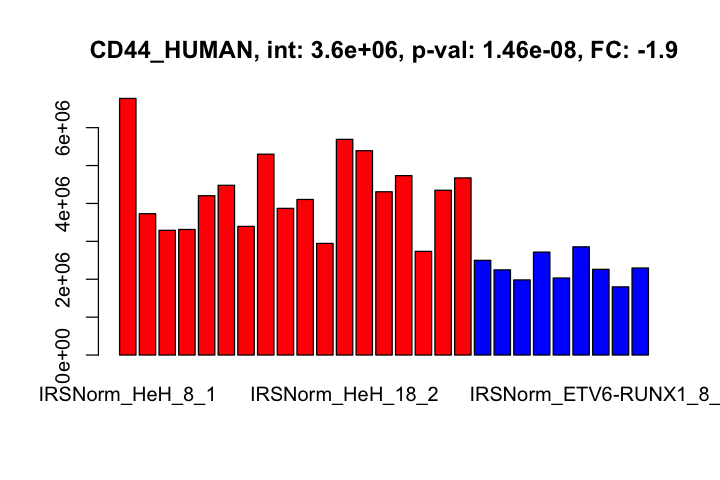

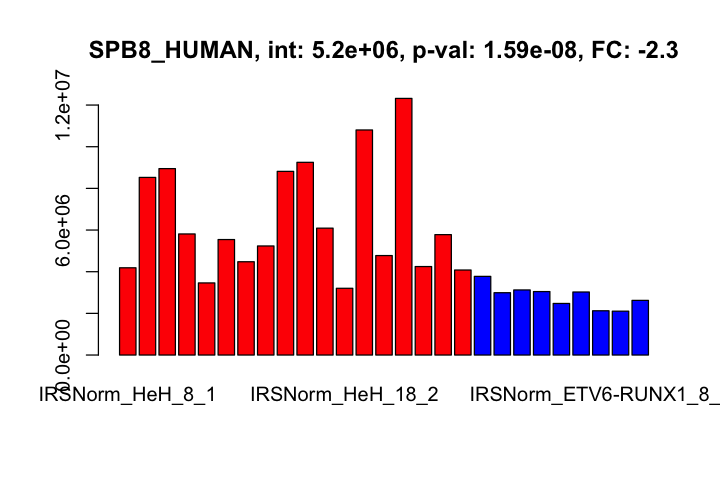

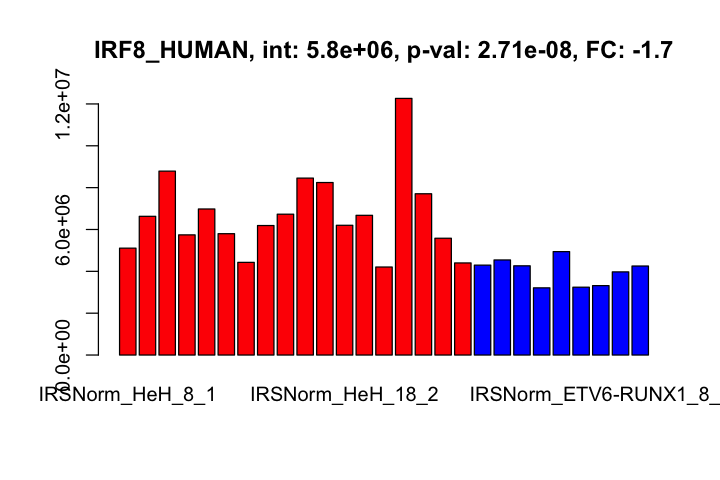

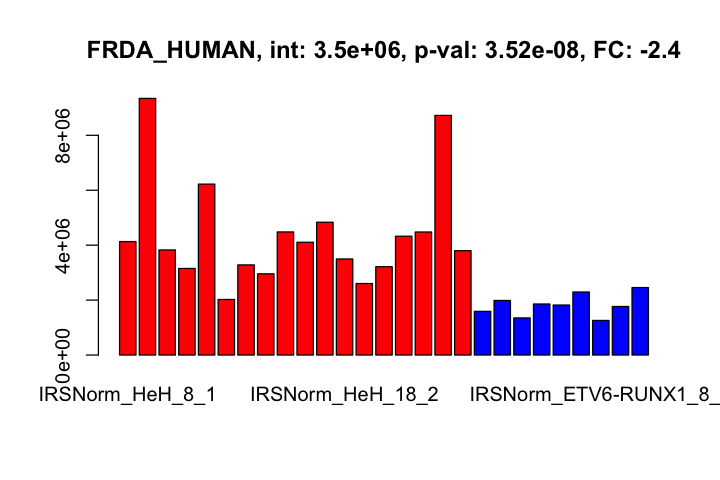

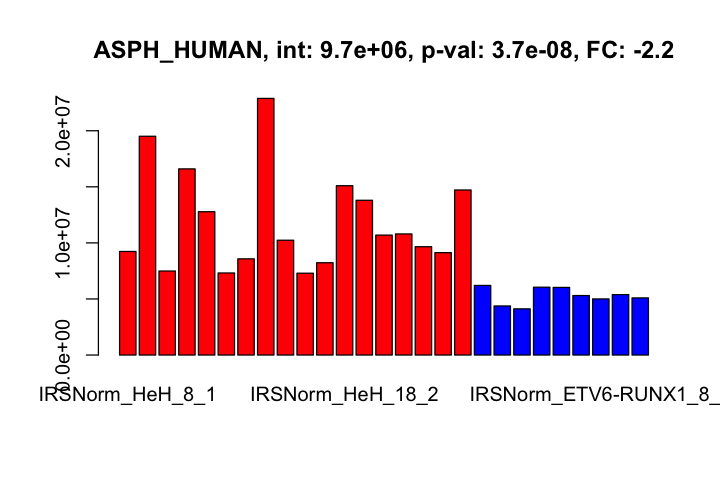

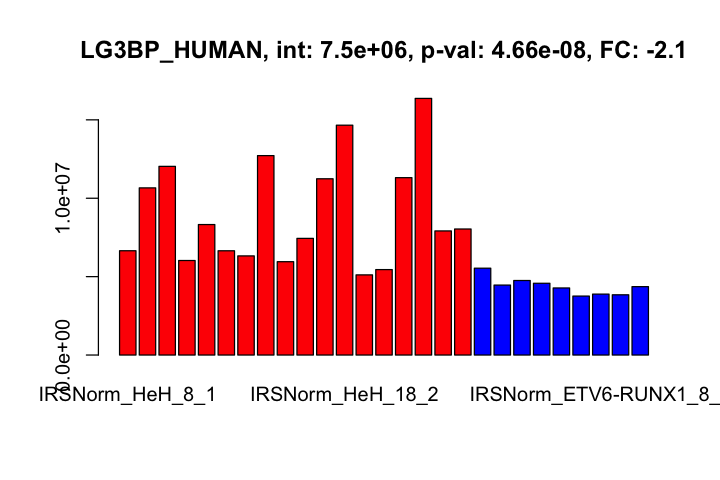

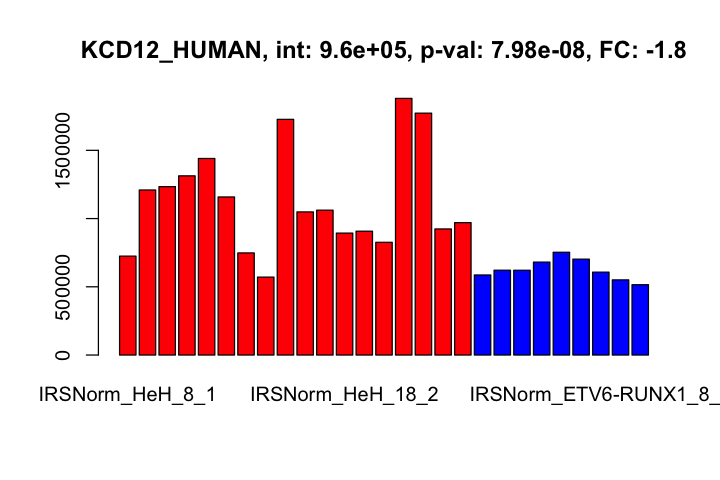

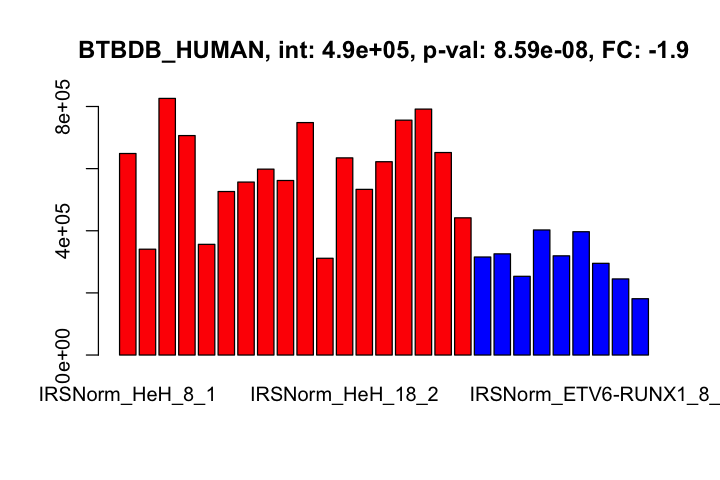

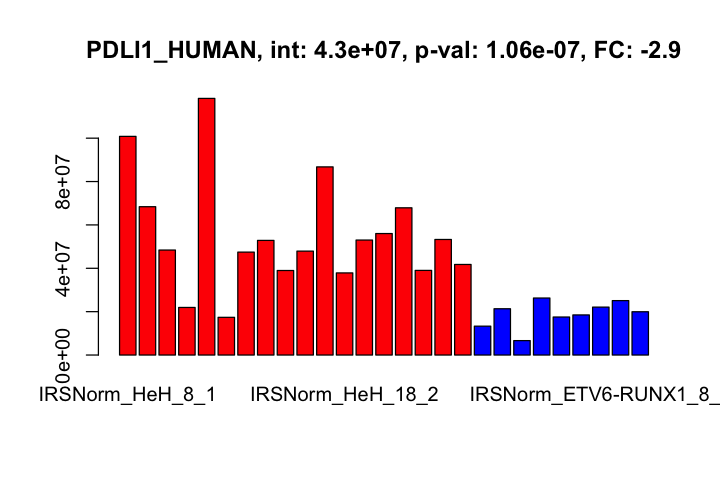

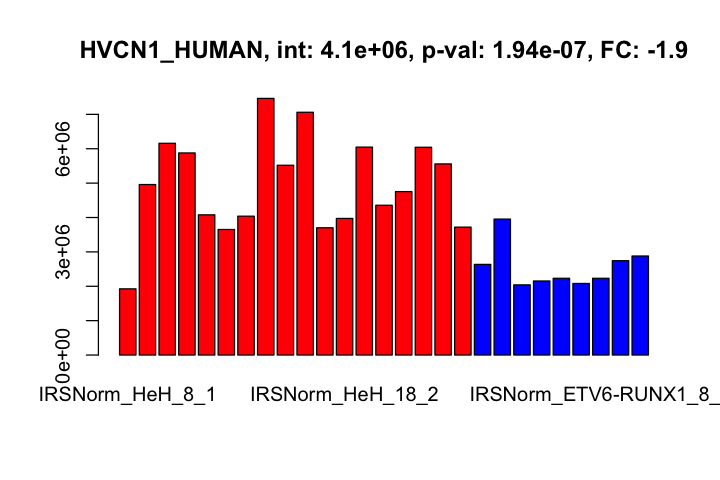

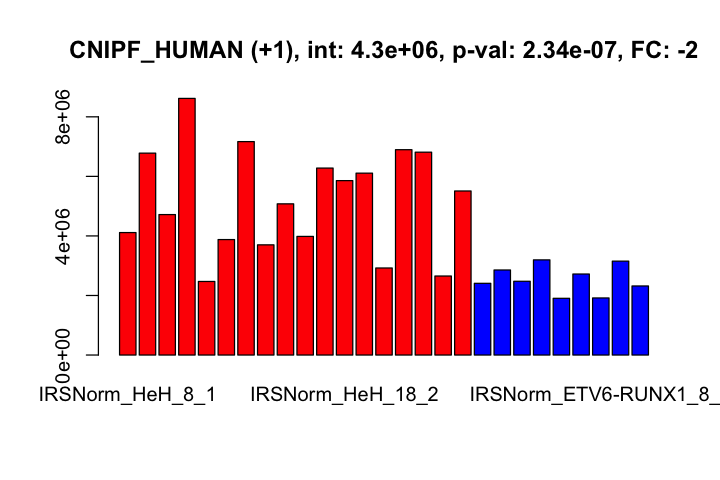

In [23]:
# ============== individual protein expression plots ===========================

# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them into one data frame
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# set plot size, make plots, reset plot size
set_plot_dimensions(6, 4)                      
plot_top_tags(results, length(HeH), length(ETV6), 25)
set_plot_dimensions(width, height)

---
## Save the `results` frame to TSV file

In [27]:
write.table(results, "IRS_R_averages_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [25]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.8.12    edgeR_3.24.3    limma_3.38.3    scales_1.0.0   
 [5] forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1   purrr_0.3.2    
 [9] readr_1.3.1     tidyr_0.8.3     tibble_2.1.1    ggplot2_3.1.0  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.3.3     
[13] pi